In [2]:
import sys
import os
from IPython.display import Image
import json
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.dom.minidom as minidom
import xml.etree.cElementTree as cet
import xml.etree.ElementTree as et
%matplotlib inline

{'silver': 6623, 'white': 6082, 'black': 5555, 'red': 2722, 'grey': 2034, 'orange': 959, 'blue': 689, 'green': 445, 'beige': 140, 'yellow': 120, 'golden': 90, 'gray': 50, 'purple': 40, 'brown': 40, 'fantasy': 20, 'pink': 10, 'non-existent': 10}
Classes 17


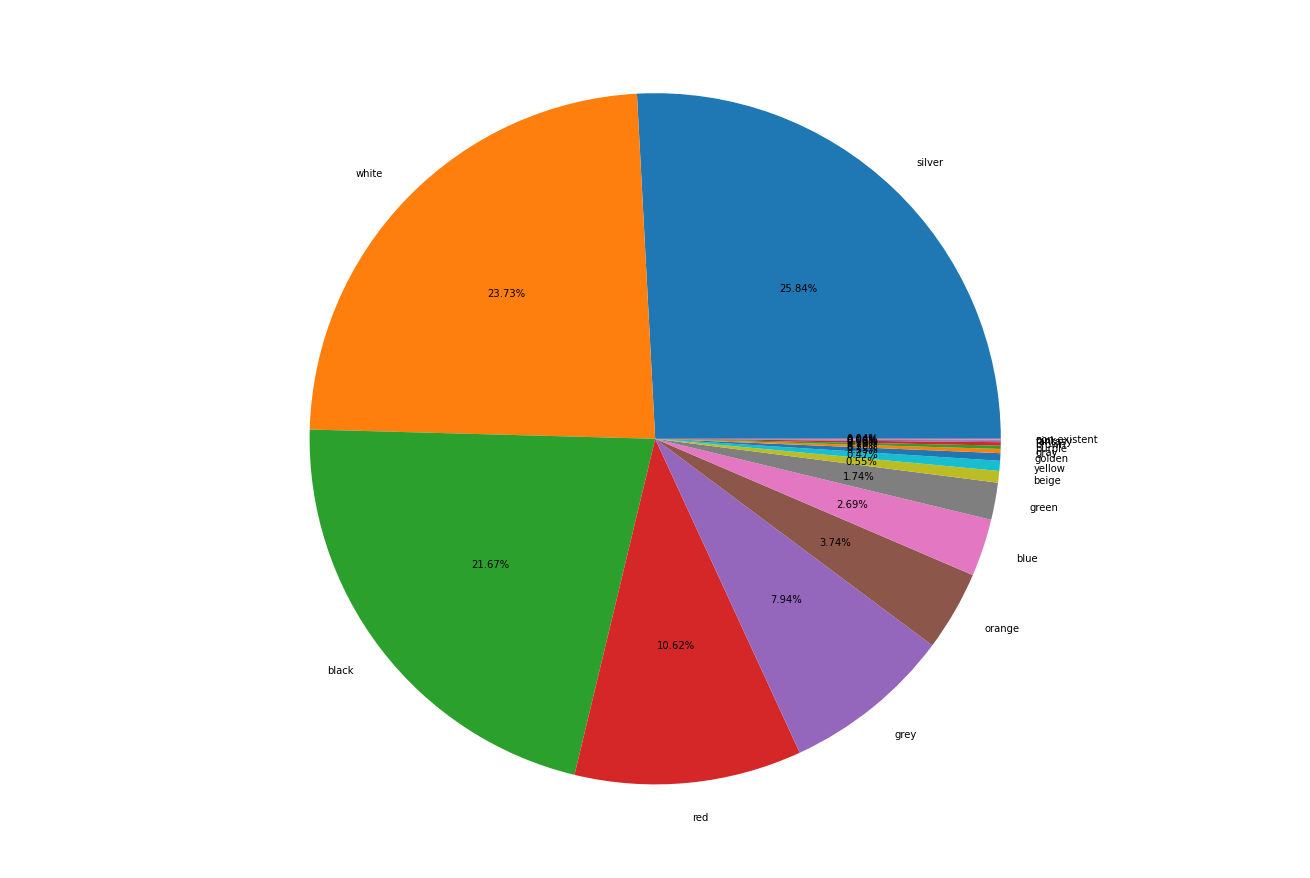

In [3]:
import pandas as pd 
dataset = pd.read_csv('./colour.csv')
value_counts = dict(dataset['label'].value_counts())
print(value_counts)

class2idx = {}
idx=0
for key in value_counts.keys():
    class2idx[key]=idx
    idx+=1

idx2class = {v: k for k, v in class2idx.items()}

dataset['label'].replace(class2idx, inplace=True)

from matplotlib import pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_axes([0,0,3,3])
ax.axis('equal')
colours = value_counts.keys()
print('Classes',len(colours))
counts = value_counts.values()
ax.pie(counts, labels = colours,autopct='%1.2f%%')
plt.show()

In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.image as img
import torchvision.transforms as transforms
class VehicleColourDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        image.resize()
        if self.transform is not None:
            image = self.transform(image)
        return image, label
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize((64,64))])
train, valid_data = train_test_split(dataset, stratify=dataset.label, test_size=0.2)
working_folder = "/home/anirban/ResearchTools/DL_Experiments/video_datasets/data/dataset2"
train_data = VehicleColourDataset(train, working_folder,trans)
valid_data = VehicleColourDataset(valid_data, working_folder,trans)

training images
torch.Size([3, 64, 64])


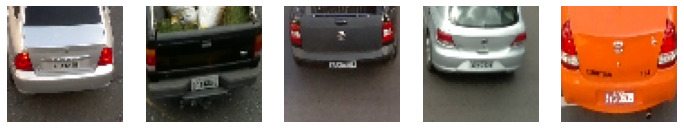

In [5]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
batch_size = 16
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=False)

print(trainimages[0].size())

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class Lenet5Basic(nn.Module):
  def __init__(self, n_classes):
    super(Lenet5Basic, self).__init__()
    self.n_classes = n_classes

    self.classification = nn.Sequential(
        nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size= 3, stride= 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2),
        nn.Conv2d(in_channels= 32, out_channels = 64, kernel_size= 3, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Conv2d(in_channels=64, out_channels= 128, kernel_size= 3, stride= 1, padding = 2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features= 46208, out_features= 128, bias = False),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features = self.n_classes, bias = False),
    )

  def forward(self, x):
    logits = self.classification(x)
    prob_of_class = F.softmax(logits, dim = 1 )
    return logits#, prob_of_class



In [7]:
from torchsummary import summary
model = Lenet5Basic(17)
summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 66, 66]             896
              ReLU-2           [-1, 32, 66, 66]               0
         MaxPool2d-3           [-1, 32, 33, 33]               0
            Conv2d-4           [-1, 64, 35, 35]          18,496
              ReLU-5           [-1, 64, 35, 35]               0
         MaxPool2d-6           [-1, 64, 17, 17]               0
            Conv2d-7          [-1, 128, 19, 19]          73,856
              ReLU-8          [-1, 128, 19, 19]               0
           Flatten-9                [-1, 46208]               0
           Linear-10                  [-1, 128]       5,914,624
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 17]           2,176
Total params: 6,010,048
Trainable params: 6,010,048
Non-trainable params: 0
---------------------------

In [8]:
num_epochs = 50
num_classes = 17
batch_size = 16
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

def save_ckp(model, optimizer,epoch,file_prefix):
    checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
    filename=file_prefix+"_"+str(epoch)+".pth"
    torch.save(checkpoint, filename)

In [9]:
%%time
# keeping-track-of-losses 
device = torch.device('cpu')
train_losses = []
valid_losses = []
file_prefix="./models/color/color_checkpoint"
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    batch_no =0
    for data, target in train_loader:
        print("Batch",batch_no)
        # move-tensors-to-GPU 
#         print(data,type(data))
#         print(target,type(target))
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        batch_no +=1
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print("Training Losses",train_losses)
    print("Valid Losses",valid_losses)
    
    save_ckp(model,optimizer,epoch,file_prefix)

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


Batch 831
Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930


Batch 338
Batch 339
Batch 340
Batch 341
Batch 342
Batch 343
Batch 344
Batch 345
Batch 346
Batch 347
Batch 348
Batch 349
Batch 350
Batch 351
Batch 352
Batch 353
Batch 354
Batch 355
Batch 356
Batch 357
Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384
Batch 385
Batch 386
Batch 387
Batch 388
Batch 389
Batch 390
Batch 391
Batch 392
Batch 393
Batch 394
Batch 395
Batch 396
Batch 397
Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407
Batch 408
Batch 409
Batch 410
Batch 411
Batch 412
Batch 413
Batch 414
Batch 415
Batch 416
Batch 417
Batch 418
Batch 419
Batch 420
Batch 421
Batch 422
Batch 423
Batch 424
Batch 425
Batch 426
Batch 427
Batch 428
Batch 429
Batch 430
Batch 431
Batch 432
Batch 433
Batch 434
Batch 435
Batch 436
Batch 437


Batch 1144
Batch 1145
Batch 1146
Batch 1147
Batch 1148
Batch 1149
Batch 1150
Batch 1151
Batch 1152
Batch 1153
Batch 1154
Batch 1155
Batch 1156
Batch 1157
Batch 1158
Batch 1159
Batch 1160
Batch 1161
Batch 1162
Batch 1163
Batch 1164
Batch 1165
Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170
Batch 1171
Batch 1172
Batch 1173
Batch 1174
Batch 1175
Batch 1176
Batch 1177
Batch 1178
Batch 1179
Batch 1180
Batch 1181
Batch 1182
Batch 1183
Batch 1184
Batch 1185
Batch 1186
Batch 1187
Batch 1188
Batch 1189
Batch 1190
Batch 1191
Batch 1192
Batch 1193
Batch 1194
Batch 1195
Batch 1196
Batch 1197
Batch 1198
Batch 1199
Batch 1200
Batch 1201
Batch 1202
Batch 1203
Batch 1204
Batch 1205
Batch 1206
Batch 1207
Batch 1208
Batch 1209
Batch 1210
Batch 1211
Batch 1212
Batch 1213
Batch 1214
Batch 1215
Batch 1216
Batch 1217
Batch 1218
Batch 1219
Batch 1220
Batch 1221
Batch 1222
Batch 1223
Batch 1224
Batch 1225
Batch 1226
Batch 1227
Batch 1228
Batch 1229
Batch 1230
Batch 1231
Batch 1232
Batch 1233
Batch 1234

Batch 662
Batch 663
Batch 664
Batch 665
Batch 666
Batch 667
Batch 668
Batch 669
Batch 670
Batch 671
Batch 672
Batch 673
Batch 674
Batch 675
Batch 676
Batch 677
Batch 678
Batch 679
Batch 680
Batch 681
Batch 682
Batch 683
Batch 684
Batch 685
Batch 686
Batch 687
Batch 688
Batch 689
Batch 690
Batch 691
Batch 692
Batch 693
Batch 694
Batch 695
Batch 696
Batch 697
Batch 698
Batch 699
Batch 700
Batch 701
Batch 702
Batch 703
Batch 704
Batch 705
Batch 706
Batch 707
Batch 708
Batch 709
Batch 710
Batch 711
Batch 712
Batch 713
Batch 714
Batch 715
Batch 716
Batch 717
Batch 718
Batch 719
Batch 720
Batch 721
Batch 722
Batch 723
Batch 724
Batch 725
Batch 726
Batch 727
Batch 728
Batch 729
Batch 730
Batch 731
Batch 732
Batch 733
Batch 734
Batch 735
Batch 736
Batch 737
Batch 738
Batch 739
Batch 740
Batch 741
Batch 742
Batch 743
Batch 744
Batch 745
Batch 746
Batch 747
Batch 748
Batch 749
Batch 750
Batch 751
Batch 752
Batch 753
Batch 754
Batch 755
Batch 756
Batch 757
Batch 758
Batch 759
Batch 760
Batch 761


Batch 162
Batch 163
Batch 164
Batch 165
Batch 166
Batch 167
Batch 168
Batch 169
Batch 170
Batch 171
Batch 172
Batch 173
Batch 174
Batch 175
Batch 176
Batch 177
Batch 178
Batch 179
Batch 180
Batch 181
Batch 182
Batch 183
Batch 184
Batch 185
Batch 186
Batch 187
Batch 188
Batch 189
Batch 190
Batch 191
Batch 192
Batch 193
Batch 194
Batch 195
Batch 196
Batch 197
Batch 198
Batch 199
Batch 200
Batch 201
Batch 202
Batch 203
Batch 204
Batch 205
Batch 206
Batch 207
Batch 208
Batch 209
Batch 210
Batch 211
Batch 212
Batch 213
Batch 214
Batch 215
Batch 216
Batch 217
Batch 218
Batch 219
Batch 220
Batch 221
Batch 222
Batch 223
Batch 224
Batch 225
Batch 226
Batch 227
Batch 228
Batch 229
Batch 230
Batch 231
Batch 232
Batch 233
Batch 234
Batch 235
Batch 236
Batch 237
Batch 238
Batch 239
Batch 240
Batch 241
Batch 242
Batch 243
Batch 244
Batch 245
Batch 246
Batch 247
Batch 248
Batch 249
Batch 250
Batch 251
Batch 252
Batch 253
Batch 254
Batch 255
Batch 256
Batch 257
Batch 258
Batch 259
Batch 260
Batch 261


Batch 982
Batch 983
Batch 984
Batch 985
Batch 986
Batch 987
Batch 988
Batch 989
Batch 990
Batch 991
Batch 992
Batch 993
Batch 994
Batch 995
Batch 996
Batch 997
Batch 998
Batch 999
Batch 1000
Batch 1001
Batch 1002
Batch 1003
Batch 1004
Batch 1005
Batch 1006
Batch 1007
Batch 1008
Batch 1009
Batch 1010
Batch 1011
Batch 1012
Batch 1013
Batch 1014
Batch 1015
Batch 1016
Batch 1017
Batch 1018
Batch 1019
Batch 1020
Batch 1021
Batch 1022
Batch 1023
Batch 1024
Batch 1025
Batch 1026
Batch 1027
Batch 1028
Batch 1029
Batch 1030
Batch 1031
Batch 1032
Batch 1033
Batch 1034
Batch 1035
Batch 1036
Batch 1037
Batch 1038
Batch 1039
Batch 1040
Batch 1041
Batch 1042
Batch 1043
Batch 1044
Batch 1045
Batch 1046
Batch 1047
Batch 1048
Batch 1049
Batch 1050
Batch 1051
Batch 1052
Batch 1053
Batch 1054
Batch 1055
Batch 1056
Batch 1057
Batch 1058
Batch 1059
Batch 1060
Batch 1061
Batch 1062
Batch 1063
Batch 1064
Batch 1065
Batch 1066
Batch 1067
Batch 1068
Batch 1069
Batch 1070
Batch 1071
Batch 1072
Batch 1073
Batch 

Batch 478
Batch 479
Batch 480
Batch 481
Batch 482
Batch 483
Batch 484
Batch 485
Batch 486
Batch 487
Batch 488
Batch 489
Batch 490
Batch 491
Batch 492
Batch 493
Batch 494
Batch 495
Batch 496
Batch 497
Batch 498
Batch 499
Batch 500
Batch 501
Batch 502
Batch 503
Batch 504
Batch 505
Batch 506
Batch 507
Batch 508
Batch 509
Batch 510
Batch 511
Batch 512
Batch 513
Batch 514
Batch 515
Batch 516
Batch 517
Batch 518
Batch 519
Batch 520
Batch 521
Batch 522
Batch 523
Batch 524
Batch 525
Batch 526
Batch 527
Batch 528
Batch 529
Batch 530
Batch 531
Batch 532
Batch 533
Batch 534
Batch 535
Batch 536
Batch 537
Batch 538
Batch 539
Batch 540
Batch 541
Batch 542
Batch 543
Batch 544
Batch 545
Batch 546
Batch 547
Batch 548
Batch 549
Batch 550
Batch 551
Batch 552
Batch 553
Batch 554
Batch 555
Batch 556
Batch 557
Batch 558
Batch 559
Batch 560
Batch 561
Batch 562
Batch 563
Batch 564
Batch 565
Batch 566
Batch 567
Batch 568
Batch 569
Batch 570
Batch 571
Batch 572
Batch 573
Batch 574
Batch 575
Batch 576
Batch 577


Batch 1272
Batch 1273
Batch 1274
Batch 1275
Batch 1276
Batch 1277
Batch 1278
Batch 1279
Batch 1280
Batch 1281
Epoch: 5 	Training Loss: 0.054491 	Validation Loss: 0.112670
Training Losses [0.6830035842323178, 0.2543588413661193, 0.11451286318170167, 0.07841050036168465, 0.05449099157828104]
Valid Losses [0.4525860456275233, 0.19429147676784594, 0.1818280115628134, 0.18558308301792217, 0.11266986912427]
Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Ba

Batch 790
Batch 791
Batch 792
Batch 793
Batch 794
Batch 795
Batch 796
Batch 797
Batch 798
Batch 799
Batch 800
Batch 801
Batch 802
Batch 803
Batch 804
Batch 805
Batch 806
Batch 807
Batch 808
Batch 809
Batch 810
Batch 811
Batch 812
Batch 813
Batch 814
Batch 815
Batch 816
Batch 817
Batch 818
Batch 819
Batch 820
Batch 821
Batch 822
Batch 823
Batch 824
Batch 825
Batch 826
Batch 827
Batch 828
Batch 829
Batch 830
Batch 831
Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889


Batch 278
Batch 279
Batch 280
Batch 281
Batch 282
Batch 283
Batch 284
Batch 285
Batch 286
Batch 287
Batch 288
Batch 289
Batch 290
Batch 291
Batch 292
Batch 293
Batch 294
Batch 295
Batch 296
Batch 297
Batch 298
Batch 299
Batch 300
Batch 301
Batch 302
Batch 303
Batch 304
Batch 305
Batch 306
Batch 307
Batch 308
Batch 309
Batch 310
Batch 311
Batch 312
Batch 313
Batch 314
Batch 315
Batch 316
Batch 317
Batch 318
Batch 319
Batch 320
Batch 321
Batch 322
Batch 323
Batch 324
Batch 325
Batch 326
Batch 327
Batch 328
Batch 329
Batch 330
Batch 331
Batch 332
Batch 333
Batch 334
Batch 335
Batch 336
Batch 337
Batch 338
Batch 339
Batch 340
Batch 341
Batch 342
Batch 343
Batch 344
Batch 345
Batch 346
Batch 347
Batch 348
Batch 349
Batch 350
Batch 351
Batch 352
Batch 353
Batch 354
Batch 355
Batch 356
Batch 357
Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377


Batch 1090
Batch 1091
Batch 1092
Batch 1093
Batch 1094
Batch 1095
Batch 1096
Batch 1097
Batch 1098
Batch 1099
Batch 1100
Batch 1101
Batch 1102
Batch 1103
Batch 1104
Batch 1105
Batch 1106
Batch 1107
Batch 1108
Batch 1109
Batch 1110
Batch 1111
Batch 1112
Batch 1113
Batch 1114
Batch 1115
Batch 1116
Batch 1117
Batch 1118
Batch 1119
Batch 1120
Batch 1121
Batch 1122
Batch 1123
Batch 1124
Batch 1125
Batch 1126
Batch 1127
Batch 1128
Batch 1129
Batch 1130
Batch 1131
Batch 1132
Batch 1133
Batch 1134
Batch 1135
Batch 1136
Batch 1137
Batch 1138
Batch 1139
Batch 1140
Batch 1141
Batch 1142
Batch 1143
Batch 1144
Batch 1145
Batch 1146
Batch 1147
Batch 1148
Batch 1149
Batch 1150
Batch 1151
Batch 1152
Batch 1153
Batch 1154
Batch 1155
Batch 1156
Batch 1157
Batch 1158
Batch 1159
Batch 1160
Batch 1161
Batch 1162
Batch 1163
Batch 1164
Batch 1165
Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170
Batch 1171
Batch 1172
Batch 1173
Batch 1174
Batch 1175
Batch 1176
Batch 1177
Batch 1178
Batch 1179
Batch 1180

Batch 583
Batch 584
Batch 585
Batch 586
Batch 587
Batch 588
Batch 589
Batch 590
Batch 591
Batch 592
Batch 593
Batch 594
Batch 595
Batch 596
Batch 597
Batch 598
Batch 599
Batch 600
Batch 601
Batch 602
Batch 603
Batch 604
Batch 605
Batch 606
Batch 607
Batch 608
Batch 609
Batch 610
Batch 611
Batch 612
Batch 613
Batch 614
Batch 615
Batch 616
Batch 617
Batch 618
Batch 619
Batch 620
Batch 621
Batch 622
Batch 623
Batch 624
Batch 625
Batch 626
Batch 627
Batch 628
Batch 629
Batch 630
Batch 631
Batch 632
Batch 633
Batch 634
Batch 635
Batch 636
Batch 637
Batch 638
Batch 639
Batch 640
Batch 641
Batch 642
Batch 643
Batch 644
Batch 645
Batch 646
Batch 647
Batch 648
Batch 649
Batch 650
Batch 651
Batch 652
Batch 653
Batch 654
Batch 655
Batch 656
Batch 657
Batch 658
Batch 659
Batch 660
Batch 661
Batch 662
Batch 663
Batch 664
Batch 665
Batch 666
Batch 667
Batch 668
Batch 669
Batch 670
Batch 671
Batch 672
Batch 673
Batch 674
Batch 675
Batch 676
Batch 677
Batch 678
Batch 679
Batch 680
Batch 681
Batch 682


Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
Batch 111
Batch 112
Batch 113
Batch 114
Batch 115
Batch 116
Batch 117
Batch 118
Batch 119
Batch 120
Batch 121
Batch 122
Batch 123
Batch 124
Batch 125
Batch 126
Batch 127
Batch 128
Batch 129
Batch 130
Batch 131
Batch 132
Batch 133
Batch 134
Batch 135
Batch 136
Batch 137
Batch 138
Batch 139
Batch 140
Batch 141
Batch 142
Batch 143
Batch 144
Batch 145
Batch 146
Batch 147
Batch 148
Batch 149
Batch 150
Batch 151
Batch 152
Batch 153
Batch 154
Batch 155
Batch 156
Batch 157
Batch 158
Batch 159
Batch 160
Batch 161
Ba

Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930
Batch 931
Batch 932
Batch 933
Batch 934
Batch 935
Batch 936
Batch 937
Batch 938
Batch 939
Batch 940
Batch 941
Batch 942
Batch 943
Batch 944
Batch 945
Batch 946
Batch 947
Batch 948
Batch 949
Batch 950
Batch 951
Batch 952
Batch 953
Batch 954
Batch 955
Batch 956
Batch 957
Batch 958
Batch 959
Batch 960
Batch 961
Batch 962
Batch 963
Batch 964
Batch 965
Batch 966
Batch 967
Batch 968
Batch 969
Batch 970
Batch 971
Batch 972
Batch 973
Batch 974
Batch 975
Batch 976
Batch 977
Batch 978
Batch 979
Batch 980
Batch 981


Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384
Batch 385
Batch 386
Batch 387
Batch 388
Batch 389
Batch 390
Batch 391
Batch 392
Batch 393
Batch 394
Batch 395
Batch 396
Batch 397
Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407
Batch 408
Batch 409
Batch 410
Batch 411
Batch 412
Batch 413
Batch 414
Batch 415
Batch 416
Batch 417
Batch 418
Batch 419
Batch 420
Batch 421
Batch 422
Batch 423
Batch 424
Batch 425
Batch 426
Batch 427
Batch 428
Batch 429
Batch 430
Batch 431
Batch 432
Batch 433
Batch 434
Batch 435
Batch 436
Batch 437
Batch 438
Batch 439
Batch 440
Batch 441
Batch 442
Batch 443
Batch 444
Batch 445
Batch 446
Batch 447
Batch 448
Batch 449
Batch 450
Batch 451
Batch 452
Batch 453
Batch 454
Batch 455
Batch 456
Batch 457


Batch 1162
Batch 1163
Batch 1164
Batch 1165
Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170
Batch 1171
Batch 1172
Batch 1173
Batch 1174
Batch 1175
Batch 1176
Batch 1177
Batch 1178
Batch 1179
Batch 1180
Batch 1181
Batch 1182
Batch 1183
Batch 1184
Batch 1185
Batch 1186
Batch 1187
Batch 1188
Batch 1189
Batch 1190
Batch 1191
Batch 1192
Batch 1193
Batch 1194
Batch 1195
Batch 1196
Batch 1197
Batch 1198
Batch 1199
Batch 1200
Batch 1201
Batch 1202
Batch 1203
Batch 1204
Batch 1205
Batch 1206
Batch 1207
Batch 1208
Batch 1209
Batch 1210
Batch 1211
Batch 1212
Batch 1213
Batch 1214
Batch 1215
Batch 1216
Batch 1217
Batch 1218
Batch 1219
Batch 1220
Batch 1221
Batch 1222
Batch 1223
Batch 1224
Batch 1225
Batch 1226
Batch 1227
Batch 1228
Batch 1229
Batch 1230
Batch 1231
Batch 1232
Batch 1233
Batch 1234
Batch 1235
Batch 1236
Batch 1237
Batch 1238
Batch 1239
Batch 1240
Batch 1241
Batch 1242
Batch 1243
Batch 1244
Batch 1245
Batch 1246
Batch 1247
Batch 1248
Batch 1249
Batch 1250
Batch 1251
Batch 1252

Batch 648
Batch 649
Batch 650
Batch 651
Batch 652
Batch 653
Batch 654
Batch 655
Batch 656
Batch 657
Batch 658
Batch 659
Batch 660
Batch 661
Batch 662
Batch 663
Batch 664
Batch 665
Batch 666
Batch 667
Batch 668
Batch 669
Batch 670
Batch 671
Batch 672
Batch 673
Batch 674
Batch 675
Batch 676
Batch 677
Batch 678
Batch 679
Batch 680
Batch 681
Batch 682
Batch 683
Batch 684
Batch 685
Batch 686
Batch 687
Batch 688
Batch 689
Batch 690
Batch 691
Batch 692
Batch 693
Batch 694
Batch 695
Batch 696
Batch 697
Batch 698
Batch 699
Batch 700
Batch 701
Batch 702
Batch 703
Batch 704
Batch 705
Batch 706
Batch 707
Batch 708
Batch 709
Batch 710
Batch 711
Batch 712
Batch 713
Batch 714
Batch 715
Batch 716
Batch 717
Batch 718
Batch 719
Batch 720
Batch 721
Batch 722
Batch 723
Batch 724
Batch 725
Batch 726
Batch 727
Batch 728
Batch 729
Batch 730
Batch 731
Batch 732
Batch 733
Batch 734
Batch 735
Batch 736
Batch 737
Batch 738
Batch 739
Batch 740
Batch 741
Batch 742
Batch 743
Batch 744
Batch 745
Batch 746
Batch 747


Batch 114
Batch 115
Batch 116
Batch 117
Batch 118
Batch 119
Batch 120
Batch 121
Batch 122
Batch 123
Batch 124
Batch 125
Batch 126
Batch 127
Batch 128
Batch 129
Batch 130
Batch 131
Batch 132
Batch 133
Batch 134
Batch 135
Batch 136
Batch 137
Batch 138
Batch 139
Batch 140
Batch 141
Batch 142
Batch 143
Batch 144
Batch 145
Batch 146
Batch 147
Batch 148
Batch 149
Batch 150
Batch 151
Batch 152
Batch 153
Batch 154
Batch 155
Batch 156
Batch 157
Batch 158
Batch 159
Batch 160
Batch 161
Batch 162
Batch 163
Batch 164
Batch 165
Batch 166
Batch 167
Batch 168
Batch 169
Batch 170
Batch 171
Batch 172
Batch 173
Batch 174
Batch 175
Batch 176
Batch 177
Batch 178
Batch 179
Batch 180
Batch 181
Batch 182
Batch 183
Batch 184
Batch 185
Batch 186
Batch 187
Batch 188
Batch 189
Batch 190
Batch 191
Batch 192
Batch 193
Batch 194
Batch 195
Batch 196
Batch 197
Batch 198
Batch 199
Batch 200
Batch 201
Batch 202
Batch 203
Batch 204
Batch 205
Batch 206
Batch 207
Batch 208
Batch 209
Batch 210
Batch 211
Batch 212
Batch 213


Batch 934
Batch 935
Batch 936
Batch 937
Batch 938
Batch 939
Batch 940
Batch 941
Batch 942
Batch 943
Batch 944
Batch 945
Batch 946
Batch 947
Batch 948
Batch 949
Batch 950
Batch 951
Batch 952
Batch 953
Batch 954
Batch 955
Batch 956
Batch 957
Batch 958
Batch 959
Batch 960
Batch 961
Batch 962
Batch 963
Batch 964
Batch 965
Batch 966
Batch 967
Batch 968
Batch 969
Batch 970
Batch 971
Batch 972
Batch 973
Batch 974
Batch 975
Batch 976
Batch 977
Batch 978
Batch 979
Batch 980
Batch 981
Batch 982
Batch 983
Batch 984
Batch 985
Batch 986
Batch 987
Batch 988
Batch 989
Batch 990
Batch 991
Batch 992
Batch 993
Batch 994
Batch 995
Batch 996
Batch 997
Batch 998
Batch 999
Batch 1000
Batch 1001
Batch 1002
Batch 1003
Batch 1004
Batch 1005
Batch 1006
Batch 1007
Batch 1008
Batch 1009
Batch 1010
Batch 1011
Batch 1012
Batch 1013
Batch 1014
Batch 1015
Batch 1016
Batch 1017
Batch 1018
Batch 1019
Batch 1020
Batch 1021
Batch 1022
Batch 1023
Batch 1024
Batch 1025
Batch 1026
Batch 1027
Batch 1028
Batch 1029
Batch 1030

Batch 396
Batch 397
Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407
Batch 408
Batch 409
Batch 410
Batch 411
Batch 412
Batch 413
Batch 414
Batch 415
Batch 416
Batch 417
Batch 418
Batch 419
Batch 420
Batch 421
Batch 422
Batch 423
Batch 424
Batch 425
Batch 426
Batch 427
Batch 428
Batch 429
Batch 430
Batch 431
Batch 432
Batch 433
Batch 434
Batch 435
Batch 436
Batch 437
Batch 438
Batch 439
Batch 440
Batch 441
Batch 442
Batch 443
Batch 444
Batch 445
Batch 446
Batch 447
Batch 448
Batch 449
Batch 450
Batch 451
Batch 452
Batch 453
Batch 454
Batch 455
Batch 456
Batch 457
Batch 458
Batch 459
Batch 460
Batch 461
Batch 462
Batch 463
Batch 464
Batch 465
Batch 466
Batch 467
Batch 468
Batch 469
Batch 470
Batch 471
Batch 472
Batch 473
Batch 474
Batch 475
Batch 476
Batch 477
Batch 478
Batch 479
Batch 480
Batch 481
Batch 482
Batch 483
Batch 484
Batch 485
Batch 486
Batch 487
Batch 488
Batch 489
Batch 490
Batch 491
Batch 492
Batch 493
Batch 494
Batch 495


Batch 1196
Batch 1197
Batch 1198
Batch 1199
Batch 1200
Batch 1201
Batch 1202
Batch 1203
Batch 1204
Batch 1205
Batch 1206
Batch 1207
Batch 1208
Batch 1209
Batch 1210
Batch 1211
Batch 1212
Batch 1213
Batch 1214
Batch 1215
Batch 1216
Batch 1217
Batch 1218
Batch 1219
Batch 1220
Batch 1221
Batch 1222
Batch 1223
Batch 1224
Batch 1225
Batch 1226
Batch 1227
Batch 1228
Batch 1229
Batch 1230
Batch 1231
Batch 1232
Batch 1233
Batch 1234
Batch 1235
Batch 1236
Batch 1237
Batch 1238
Batch 1239
Batch 1240
Batch 1241
Batch 1242
Batch 1243
Batch 1244
Batch 1245
Batch 1246
Batch 1247
Batch 1248
Batch 1249
Batch 1250
Batch 1251
Batch 1252
Batch 1253
Batch 1254
Batch 1255
Batch 1256
Batch 1257
Batch 1258
Batch 1259
Batch 1260
Batch 1261
Batch 1262
Batch 1263
Batch 1264
Batch 1265
Batch 1266
Batch 1267
Batch 1268
Batch 1269
Batch 1270
Batch 1271
Batch 1272
Batch 1273
Batch 1274
Batch 1275
Batch 1276
Batch 1277
Batch 1278
Batch 1279
Batch 1280
Batch 1281
Epoch: 13 	Training Loss: 0.011422 	Validation Loss: 0

Batch 674
Batch 675
Batch 676
Batch 677
Batch 678
Batch 679
Batch 680
Batch 681
Batch 682
Batch 683
Batch 684
Batch 685
Batch 686
Batch 687
Batch 688
Batch 689
Batch 690
Batch 691
Batch 692
Batch 693
Batch 694
Batch 695
Batch 696
Batch 697
Batch 698
Batch 699
Batch 700
Batch 701
Batch 702
Batch 703
Batch 704
Batch 705
Batch 706
Batch 707
Batch 708
Batch 709
Batch 710
Batch 711
Batch 712
Batch 713
Batch 714
Batch 715
Batch 716
Batch 717
Batch 718
Batch 719
Batch 720
Batch 721
Batch 722
Batch 723
Batch 724
Batch 725
Batch 726
Batch 727
Batch 728
Batch 729
Batch 730
Batch 731
Batch 732
Batch 733
Batch 734
Batch 735
Batch 736
Batch 737
Batch 738
Batch 739
Batch 740
Batch 741
Batch 742
Batch 743
Batch 744
Batch 745
Batch 746
Batch 747
Batch 748
Batch 749
Batch 750
Batch 751
Batch 752
Batch 753
Batch 754
Batch 755
Batch 756
Batch 757
Batch 758
Batch 759
Batch 760
Batch 761
Batch 762
Batch 763
Batch 764
Batch 765
Batch 766
Batch 767
Batch 768
Batch 769
Batch 770
Batch 771
Batch 772
Batch 773


Batch 128
Batch 129
Batch 130
Batch 131
Batch 132
Batch 133
Batch 134
Batch 135
Batch 136
Batch 137
Batch 138
Batch 139
Batch 140
Batch 141
Batch 142
Batch 143
Batch 144
Batch 145
Batch 146
Batch 147
Batch 148
Batch 149
Batch 150
Batch 151
Batch 152
Batch 153
Batch 154
Batch 155
Batch 156
Batch 157
Batch 158
Batch 159
Batch 160
Batch 161
Batch 162
Batch 163
Batch 164
Batch 165
Batch 166
Batch 167
Batch 168
Batch 169
Batch 170
Batch 171
Batch 172
Batch 173
Batch 174
Batch 175
Batch 176
Batch 177
Batch 178
Batch 179
Batch 180
Batch 181
Batch 182
Batch 183
Batch 184
Batch 185
Batch 186
Batch 187
Batch 188
Batch 189
Batch 190
Batch 191
Batch 192
Batch 193
Batch 194
Batch 195
Batch 196
Batch 197
Batch 198
Batch 199
Batch 200
Batch 201
Batch 202
Batch 203
Batch 204
Batch 205
Batch 206
Batch 207
Batch 208
Batch 209
Batch 210
Batch 211
Batch 212
Batch 213
Batch 214
Batch 215
Batch 216
Batch 217
Batch 218
Batch 219
Batch 220
Batch 221
Batch 222
Batch 223
Batch 224
Batch 225
Batch 226
Batch 227


Batch 948
Batch 949
Batch 950
Batch 951
Batch 952
Batch 953
Batch 954
Batch 955
Batch 956
Batch 957
Batch 958
Batch 959
Batch 960
Batch 961
Batch 962
Batch 963
Batch 964
Batch 965
Batch 966
Batch 967
Batch 968
Batch 969
Batch 970
Batch 971
Batch 972
Batch 973
Batch 974
Batch 975
Batch 976
Batch 977
Batch 978
Batch 979
Batch 980
Batch 981
Batch 982
Batch 983
Batch 984
Batch 985
Batch 986
Batch 987
Batch 988
Batch 989
Batch 990
Batch 991
Batch 992
Batch 993
Batch 994
Batch 995
Batch 996
Batch 997
Batch 998
Batch 999
Batch 1000
Batch 1001
Batch 1002
Batch 1003
Batch 1004
Batch 1005
Batch 1006
Batch 1007
Batch 1008
Batch 1009
Batch 1010
Batch 1011
Batch 1012
Batch 1013
Batch 1014
Batch 1015
Batch 1016
Batch 1017
Batch 1018
Batch 1019
Batch 1020
Batch 1021
Batch 1022
Batch 1023
Batch 1024
Batch 1025
Batch 1026
Batch 1027
Batch 1028
Batch 1029
Batch 1030
Batch 1031
Batch 1032
Batch 1033
Batch 1034
Batch 1035
Batch 1036
Batch 1037
Batch 1038
Batch 1039
Batch 1040
Batch 1041
Batch 1042
Batch 1

Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407
Batch 408
Batch 409
Batch 410
Batch 411
Batch 412
Batch 413
Batch 414
Batch 415
Batch 416
Batch 417
Batch 418
Batch 419
Batch 420
Batch 421
Batch 422
Batch 423
Batch 424
Batch 425
Batch 426
Batch 427
Batch 428
Batch 429
Batch 430
Batch 431
Batch 432
Batch 433
Batch 434
Batch 435
Batch 436
Batch 437
Batch 438
Batch 439
Batch 440
Batch 441
Batch 442
Batch 443
Batch 444
Batch 445
Batch 446
Batch 447
Batch 448
Batch 449
Batch 450
Batch 451
Batch 452
Batch 453
Batch 454
Batch 455
Batch 456
Batch 457
Batch 458
Batch 459
Batch 460
Batch 461
Batch 462
Batch 463
Batch 464
Batch 465
Batch 466
Batch 467
Batch 468
Batch 469
Batch 470
Batch 471
Batch 472
Batch 473
Batch 474
Batch 475
Batch 476
Batch 477
Batch 478
Batch 479
Batch 480
Batch 481
Batch 482
Batch 483
Batch 484
Batch 485
Batch 486
Batch 487
Batch 488
Batch 489
Batch 490
Batch 491
Batch 492
Batch 493
Batch 494
Batch 495
Batch 496
Batch 497


Batch 1199
Batch 1200
Batch 1201
Batch 1202
Batch 1203
Batch 1204
Batch 1205
Batch 1206
Batch 1207
Batch 1208
Batch 1209
Batch 1210
Batch 1211
Batch 1212
Batch 1213
Batch 1214
Batch 1215
Batch 1216
Batch 1217
Batch 1218
Batch 1219
Batch 1220
Batch 1221
Batch 1222
Batch 1223
Batch 1224
Batch 1225
Batch 1226
Batch 1227
Batch 1228
Batch 1229
Batch 1230
Batch 1231
Batch 1232
Batch 1233
Batch 1234
Batch 1235
Batch 1236
Batch 1237
Batch 1238
Batch 1239
Batch 1240
Batch 1241
Batch 1242
Batch 1243
Batch 1244
Batch 1245
Batch 1246
Batch 1247
Batch 1248
Batch 1249
Batch 1250
Batch 1251
Batch 1252
Batch 1253
Batch 1254
Batch 1255
Batch 1256
Batch 1257
Batch 1258
Batch 1259
Batch 1260
Batch 1261
Batch 1262
Batch 1263
Batch 1264
Batch 1265
Batch 1266
Batch 1267
Batch 1268
Batch 1269
Batch 1270
Batch 1271
Batch 1272
Batch 1273
Batch 1274
Batch 1275
Batch 1276
Batch 1277
Batch 1278
Batch 1279
Batch 1280
Batch 1281
Epoch: 16 	Training Loss: 0.017626 	Validation Loss: 0.217088
Training Losses [0.683003

Batch 664
Batch 665
Batch 666
Batch 667
Batch 668
Batch 669
Batch 670
Batch 671
Batch 672
Batch 673
Batch 674
Batch 675
Batch 676
Batch 677
Batch 678
Batch 679
Batch 680
Batch 681
Batch 682
Batch 683
Batch 684
Batch 685
Batch 686
Batch 687
Batch 688
Batch 689
Batch 690
Batch 691
Batch 692
Batch 693
Batch 694
Batch 695
Batch 696
Batch 697
Batch 698
Batch 699
Batch 700
Batch 701
Batch 702
Batch 703
Batch 704
Batch 705
Batch 706
Batch 707
Batch 708
Batch 709
Batch 710
Batch 711
Batch 712
Batch 713
Batch 714
Batch 715
Batch 716
Batch 717
Batch 718
Batch 719
Batch 720
Batch 721
Batch 722
Batch 723
Batch 724
Batch 725
Batch 726
Batch 727
Batch 728
Batch 729
Batch 730
Batch 731
Batch 732
Batch 733
Batch 734
Batch 735
Batch 736
Batch 737
Batch 738
Batch 739
Batch 740
Batch 741
Batch 742
Batch 743
Batch 744
Batch 745
Batch 746
Batch 747
Batch 748
Batch 749
Batch 750
Batch 751
Batch 752
Batch 753
Batch 754
Batch 755
Batch 756
Batch 757
Batch 758
Batch 759
Batch 760
Batch 761
Batch 762
Batch 763


Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
Batch 111
Batch 112
Batch 113
Batch 114
Batch 115
Batch 116
Batch 117
Batch 118
Batch 119
Batch 120
Batch 121
Batch 122
Batch 123
Batch 124
Batch 125
Batch 126
Batch 127
Batch 128
Batch 129
Batch 130
Batch 131
Batch 132
Batch 133
Batch 134
Batch 135
Batch 136
Batch 137
Batch 138
Batch 139
Batch 140
Batch 141
Batch 142
Batch 143
Batch 144
Batch 145
Batch 146
Batch 147
Batch 148
Batch 149
Batch 150
Batch 151
Batch 152
Batch 153
Batch 154
Batch 155
Batch 156
Batch 157
Batch 158
Batch 159
Batch 160
Batch 161
Batch 162
Batch 163
Batch 164
Batch 165
Batch 166
Batch 167
Batch 168
Batch 169
Batch 170
Batch 171
Batch 172
Batch 173
Batch 174
Batch 175
Batch 176
Batch 177
Batch 178
Batch 179
Batch 180
Batch 181
Batch 182
Batch 183
Batch 184
Batch 185
Batch 186
Batch 187
Batch 188
Batch 189
Batch 190
Batch 191
Batch 192
Batch 193
Batch 194
Batch 195
Batch 196
Batch 197
Batch 198
Batch 199
Batch 200
Batch 201
Batch 202
Batch 203
Batch 204
Batch 205


Batch 926
Batch 927
Batch 928
Batch 929
Batch 930
Batch 931
Batch 932
Batch 933
Batch 934
Batch 935
Batch 936
Batch 937
Batch 938
Batch 939
Batch 940
Batch 941
Batch 942
Batch 943
Batch 944
Batch 945
Batch 946
Batch 947
Batch 948
Batch 949
Batch 950
Batch 951
Batch 952
Batch 953
Batch 954
Batch 955
Batch 956
Batch 957
Batch 958
Batch 959
Batch 960
Batch 961
Batch 962
Batch 963
Batch 964
Batch 965
Batch 966
Batch 967
Batch 968
Batch 969
Batch 970
Batch 971
Batch 972
Batch 973
Batch 974
Batch 975
Batch 976
Batch 977
Batch 978
Batch 979
Batch 980
Batch 981
Batch 982
Batch 983
Batch 984
Batch 985
Batch 986
Batch 987
Batch 988
Batch 989
Batch 990
Batch 991
Batch 992
Batch 993
Batch 994
Batch 995
Batch 996
Batch 997
Batch 998
Batch 999
Batch 1000
Batch 1001
Batch 1002
Batch 1003
Batch 1004
Batch 1005
Batch 1006
Batch 1007
Batch 1008
Batch 1009
Batch 1010
Batch 1011
Batch 1012
Batch 1013
Batch 1014
Batch 1015
Batch 1016
Batch 1017
Batch 1018
Batch 1019
Batch 1020
Batch 1021
Batch 1022
Batch 1

Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384
Batch 385
Batch 386
Batch 387
Batch 388
Batch 389
Batch 390
Batch 391
Batch 392
Batch 393
Batch 394
Batch 395
Batch 396
Batch 397
Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407
Batch 408
Batch 409
Batch 410
Batch 411
Batch 412
Batch 413
Batch 414
Batch 415
Batch 416
Batch 417
Batch 418
Batch 419
Batch 420
Batch 421
Batch 422
Batch 423
Batch 424
Batch 425
Batch 426
Batch 427
Batch 428
Batch 429
Batch 430
Batch 431
Batch 432
Batch 433
Batch 434
Batch 435
Batch 436
Batch 437
Batch 438
Batch 439
Batch 440
Batch 441
Batch 442
Batch 443
Batch 444
Batch 445
Batch 446
Batch 447
Batch 448
Batch 449
Batch 450
Batch 451
Batch 452
Batch 453
Batch 454
Batch 455
Batch 456
Batch 457
Batch 458
Batch 459
Batch 460
Batch 461


Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170
Batch 1171
Batch 1172
Batch 1173
Batch 1174
Batch 1175
Batch 1176
Batch 1177
Batch 1178
Batch 1179
Batch 1180
Batch 1181
Batch 1182
Batch 1183
Batch 1184
Batch 1185
Batch 1186
Batch 1187
Batch 1188
Batch 1189
Batch 1190
Batch 1191
Batch 1192
Batch 1193
Batch 1194
Batch 1195
Batch 1196
Batch 1197
Batch 1198
Batch 1199
Batch 1200
Batch 1201
Batch 1202
Batch 1203
Batch 1204
Batch 1205
Batch 1206
Batch 1207
Batch 1208
Batch 1209
Batch 1210
Batch 1211
Batch 1212
Batch 1213
Batch 1214
Batch 1215
Batch 1216
Batch 1217
Batch 1218
Batch 1219
Batch 1220
Batch 1221
Batch 1222
Batch 1223
Batch 1224
Batch 1225
Batch 1226
Batch 1227
Batch 1228
Batch 1229
Batch 1230
Batch 1231
Batch 1232
Batch 1233
Batch 1234
Batch 1235
Batch 1236
Batch 1237
Batch 1238
Batch 1239
Batch 1240
Batch 1241
Batch 1242
Batch 1243
Batch 1244
Batch 1245
Batch 1246
Batch 1247
Batch 1248
Batch 1249
Batch 1250
Batch 1251
Batch 1252
Batch 1253
Batch 1254
Batch 1255
Batch 1256

Batch 615
Batch 616
Batch 617
Batch 618
Batch 619
Batch 620
Batch 621
Batch 622
Batch 623
Batch 624
Batch 625
Batch 626
Batch 627
Batch 628
Batch 629
Batch 630
Batch 631
Batch 632
Batch 633
Batch 634
Batch 635
Batch 636
Batch 637
Batch 638
Batch 639
Batch 640
Batch 641
Batch 642
Batch 643
Batch 644
Batch 645
Batch 646
Batch 647
Batch 648
Batch 649
Batch 650
Batch 651
Batch 652
Batch 653
Batch 654
Batch 655
Batch 656
Batch 657
Batch 658
Batch 659
Batch 660
Batch 661
Batch 662
Batch 663
Batch 664
Batch 665
Batch 666
Batch 667
Batch 668
Batch 669
Batch 670
Batch 671
Batch 672
Batch 673
Batch 674
Batch 675
Batch 676
Batch 677
Batch 678
Batch 679
Batch 680
Batch 681
Batch 682
Batch 683
Batch 684
Batch 685
Batch 686
Batch 687
Batch 688
Batch 689
Batch 690
Batch 691
Batch 692
Batch 693
Batch 694
Batch 695
Batch 696
Batch 697
Batch 698
Batch 699
Batch 700
Batch 701
Batch 702
Batch 703
Batch 704
Batch 705
Batch 706
Batch 707
Batch 708
Batch 709
Batch 710
Batch 711
Batch 712
Batch 713
Batch 714


Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
Batch 111
Batch 112
Batch 113
Batch 114
Batch 115
Batch 116
Batch 117
Batch 118
Batch 119
Batch 120
Batch 121
Batch 122
Batch 123
Batch 124
Batch 125
Batch 126
Batch 127
Batch 128
Batch 129
Batch 130
Batch 131
Batch 132
Batch 133
Batch 134
Batch 135
Batch 136
Batch 137
Batch 138
Batch 139
Batch 140
Batch 141
Batch 142
Batch 143
Ba

Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930
Batch 931
Batch 932
Batch 933
Batch 934
Batch 935
Batch 936
Batch 937
Batch 938
Batch 939
Batch 940
Batch 941
Batch 942
Batch 943
Batch 944
Batch 945
Batch 946
Batch 947
Batch 948
Batch 949
Batch 950
Batch 951
Batch 952
Batch 953
Batch 954
Batch 955
Batch 956
Batch 957
Batch 958
Batch 959
Batch 960
Batch 961
Batch 962
Batch 963


Batch 288
Batch 289
Batch 290
Batch 291
Batch 292
Batch 293
Batch 294
Batch 295
Batch 296
Batch 297
Batch 298
Batch 299
Batch 300
Batch 301
Batch 302
Batch 303
Batch 304
Batch 305
Batch 306
Batch 307
Batch 308
Batch 309
Batch 310
Batch 311
Batch 312
Batch 313
Batch 314
Batch 315
Batch 316
Batch 317
Batch 318
Batch 319
Batch 320
Batch 321
Batch 322
Batch 323
Batch 324
Batch 325
Batch 326
Batch 327
Batch 328
Batch 329
Batch 330
Batch 331
Batch 332
Batch 333
Batch 334
Batch 335
Batch 336
Batch 337
Batch 338
Batch 339
Batch 340
Batch 341
Batch 342
Batch 343
Batch 344
Batch 345
Batch 346
Batch 347
Batch 348
Batch 349
Batch 350
Batch 351
Batch 352
Batch 353
Batch 354
Batch 355
Batch 356
Batch 357
Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384
Batch 385
Batch 386
Batch 387


Batch 1098
Batch 1099
Batch 1100
Batch 1101
Batch 1102
Batch 1103
Batch 1104
Batch 1105
Batch 1106
Batch 1107
Batch 1108
Batch 1109
Batch 1110
Batch 1111
Batch 1112
Batch 1113
Batch 1114
Batch 1115
Batch 1116
Batch 1117
Batch 1118
Batch 1119
Batch 1120
Batch 1121
Batch 1122
Batch 1123
Batch 1124
Batch 1125
Batch 1126
Batch 1127
Batch 1128
Batch 1129
Batch 1130
Batch 1131
Batch 1132
Batch 1133
Batch 1134
Batch 1135
Batch 1136
Batch 1137
Batch 1138
Batch 1139
Batch 1140
Batch 1141
Batch 1142
Batch 1143
Batch 1144
Batch 1145
Batch 1146
Batch 1147
Batch 1148
Batch 1149
Batch 1150
Batch 1151
Batch 1152
Batch 1153
Batch 1154
Batch 1155
Batch 1156
Batch 1157
Batch 1158
Batch 1159
Batch 1160
Batch 1161
Batch 1162
Batch 1163
Batch 1164
Batch 1165
Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170
Batch 1171
Batch 1172
Batch 1173
Batch 1174
Batch 1175
Batch 1176
Batch 1177
Batch 1178
Batch 1179
Batch 1180
Batch 1181
Batch 1182
Batch 1183
Batch 1184
Batch 1185
Batch 1186
Batch 1187
Batch 1188

Batch 528
Batch 529
Batch 530
Batch 531
Batch 532
Batch 533
Batch 534
Batch 535
Batch 536
Batch 537
Batch 538
Batch 539
Batch 540
Batch 541
Batch 542
Batch 543
Batch 544
Batch 545
Batch 546
Batch 547
Batch 548
Batch 549
Batch 550
Batch 551
Batch 552
Batch 553
Batch 554
Batch 555
Batch 556
Batch 557
Batch 558
Batch 559
Batch 560
Batch 561
Batch 562
Batch 563
Batch 564
Batch 565
Batch 566
Batch 567
Batch 568
Batch 569
Batch 570
Batch 571
Batch 572
Batch 573
Batch 574
Batch 575
Batch 576
Batch 577
Batch 578
Batch 579
Batch 580
Batch 581
Batch 582
Batch 583
Batch 584
Batch 585
Batch 586
Batch 587
Batch 588
Batch 589
Batch 590
Batch 591
Batch 592
Batch 593
Batch 594
Batch 595
Batch 596
Batch 597
Batch 598
Batch 599
Batch 600
Batch 601
Batch 602
Batch 603
Batch 604
Batch 605
Batch 606
Batch 607
Batch 608
Batch 609
Batch 610
Batch 611
Batch 612
Batch 613
Batch 614
Batch 615
Batch 616
Batch 617
Batch 618
Batch 619
Batch 620
Batch 621
Batch 622
Batch 623
Batch 624
Batch 625
Batch 626
Batch 627


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930
Batch 931


Batch 244
Batch 245
Batch 246
Batch 247
Batch 248
Batch 249
Batch 250
Batch 251
Batch 252
Batch 253
Batch 254
Batch 255
Batch 256
Batch 257
Batch 258
Batch 259
Batch 260
Batch 261
Batch 262
Batch 263
Batch 264
Batch 265
Batch 266
Batch 267
Batch 268
Batch 269
Batch 270
Batch 271
Batch 272
Batch 273
Batch 274
Batch 275
Batch 276
Batch 277
Batch 278
Batch 279
Batch 280
Batch 281
Batch 282
Batch 283
Batch 284
Batch 285
Batch 286
Batch 287
Batch 288
Batch 289
Batch 290
Batch 291
Batch 292
Batch 293
Batch 294
Batch 295
Batch 296
Batch 297
Batch 298
Batch 299
Batch 300
Batch 301
Batch 302
Batch 303
Batch 304
Batch 305
Batch 306
Batch 307
Batch 308
Batch 309
Batch 310
Batch 311
Batch 312
Batch 313
Batch 314
Batch 315
Batch 316
Batch 317
Batch 318
Batch 319
Batch 320
Batch 321
Batch 322
Batch 323
Batch 324
Batch 325
Batch 326
Batch 327
Batch 328
Batch 329
Batch 330
Batch 331
Batch 332
Batch 333
Batch 334
Batch 335
Batch 336
Batch 337
Batch 338
Batch 339
Batch 340
Batch 341
Batch 342
Batch 343


Batch 1058
Batch 1059
Batch 1060
Batch 1061
Batch 1062
Batch 1063
Batch 1064
Batch 1065
Batch 1066
Batch 1067
Batch 1068
Batch 1069
Batch 1070
Batch 1071
Batch 1072
Batch 1073
Batch 1074
Batch 1075
Batch 1076
Batch 1077
Batch 1078
Batch 1079
Batch 1080
Batch 1081
Batch 1082
Batch 1083
Batch 1084
Batch 1085
Batch 1086
Batch 1087
Batch 1088
Batch 1089
Batch 1090
Batch 1091
Batch 1092
Batch 1093
Batch 1094
Batch 1095
Batch 1096
Batch 1097
Batch 1098
Batch 1099
Batch 1100
Batch 1101
Batch 1102
Batch 1103
Batch 1104
Batch 1105
Batch 1106
Batch 1107
Batch 1108
Batch 1109
Batch 1110
Batch 1111
Batch 1112
Batch 1113
Batch 1114
Batch 1115
Batch 1116
Batch 1117
Batch 1118
Batch 1119
Batch 1120
Batch 1121
Batch 1122
Batch 1123
Batch 1124
Batch 1125
Batch 1126
Batch 1127
Batch 1128
Batch 1129
Batch 1130
Batch 1131
Batch 1132
Batch 1133
Batch 1134
Batch 1135
Batch 1136
Batch 1137
Batch 1138
Batch 1139
Batch 1140
Batch 1141
Batch 1142
Batch 1143
Batch 1144
Batch 1145
Batch 1146
Batch 1147
Batch 1148

Batch 470
Batch 471
Batch 472
Batch 473
Batch 474
Batch 475
Batch 476
Batch 477
Batch 478
Batch 479
Batch 480
Batch 481
Batch 482
Batch 483
Batch 484
Batch 485
Batch 486
Batch 487
Batch 488
Batch 489
Batch 490
Batch 491
Batch 492
Batch 493
Batch 494
Batch 495
Batch 496
Batch 497
Batch 498
Batch 499
Batch 500
Batch 501
Batch 502
Batch 503
Batch 504
Batch 505
Batch 506
Batch 507
Batch 508
Batch 509
Batch 510
Batch 511
Batch 512
Batch 513
Batch 514
Batch 515
Batch 516
Batch 517
Batch 518
Batch 519
Batch 520
Batch 521
Batch 522
Batch 523
Batch 524
Batch 525
Batch 526
Batch 527
Batch 528
Batch 529
Batch 530
Batch 531
Batch 532
Batch 533
Batch 534
Batch 535
Batch 536
Batch 537
Batch 538
Batch 539
Batch 540
Batch 541
Batch 542
Batch 543
Batch 544
Batch 545
Batch 546
Batch 547
Batch 548
Batch 549
Batch 550
Batch 551
Batch 552
Batch 553
Batch 554
Batch 555
Batch 556
Batch 557
Batch 558
Batch 559
Batch 560
Batch 561
Batch 562
Batch 563
Batch 564
Batch 565
Batch 566
Batch 567
Batch 568
Batch 569


Batch 1264
Batch 1265
Batch 1266
Batch 1267
Batch 1268
Batch 1269
Batch 1270
Batch 1271
Batch 1272
Batch 1273
Batch 1274
Batch 1275
Batch 1276
Batch 1277
Batch 1278
Batch 1279
Batch 1280
Batch 1281
Epoch: 26 	Training Loss: 0.006383 	Validation Loss: 0.164955
Training Losses [0.6830035842323178, 0.2543588413661193, 0.11451286318170167, 0.07841050036168465, 0.05449099157828104, 0.05124767556118515, 0.030347588176487632, 0.03080465630593724, 0.03723986759864872, 0.030248882207413553, 0.03086490796293764, 0.02668494062873505, 0.011422175953116284, 0.023788781493983762, 0.024097726642197215, 0.017625954351286513, 0.025229443769176643, 0.01784434788174953, 0.01885546100745122, 0.011787717156585447, 0.018104928842257468, 0.01682080611859417, 0.015540497444498974, 0.01881247778026414, 0.019022348917134568, 0.0063825865967954455]
Valid Losses [0.4525860456275233, 0.19429147676784594, 0.1818280115628134, 0.18558308301792217, 0.11266986912427, 0.141584117093171, 0.1418075516037489, 0.09944248354

Batch 694
Batch 695
Batch 696
Batch 697
Batch 698
Batch 699
Batch 700
Batch 701
Batch 702
Batch 703
Batch 704
Batch 705
Batch 706
Batch 707
Batch 708
Batch 709
Batch 710
Batch 711
Batch 712
Batch 713
Batch 714
Batch 715
Batch 716
Batch 717
Batch 718
Batch 719
Batch 720
Batch 721
Batch 722
Batch 723
Batch 724
Batch 725
Batch 726
Batch 727
Batch 728
Batch 729
Batch 730
Batch 731
Batch 732
Batch 733
Batch 734
Batch 735
Batch 736
Batch 737
Batch 738
Batch 739
Batch 740
Batch 741
Batch 742
Batch 743
Batch 744
Batch 745
Batch 746
Batch 747
Batch 748
Batch 749
Batch 750
Batch 751
Batch 752
Batch 753
Batch 754
Batch 755
Batch 756
Batch 757
Batch 758
Batch 759
Batch 760
Batch 761
Batch 762
Batch 763
Batch 764
Batch 765
Batch 766
Batch 767
Batch 768
Batch 769
Batch 770
Batch 771
Batch 772
Batch 773
Batch 774
Batch 775
Batch 776
Batch 777
Batch 778
Batch 779
Batch 780
Batch 781
Batch 782
Batch 783
Batch 784
Batch 785
Batch 786
Batch 787
Batch 788
Batch 789
Batch 790
Batch 791
Batch 792
Batch 793


Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
Batch 111
Batch 112
Batch 113
Batch 114
Batch 115
Batch 116
Batch 117
Batch 118
Batch 119
Batch 120
Batch 121
Batch 122
Batch 123
Batch 124
Batch 125
Batch 126
Batch 127
Batch 128
Batch 129
Batch 130
Batch 131
Batch 132
Batch 133
Batch 134
Batch 135
Batch 136
Batch 137
Batch 138
Batch 139
Batch 140
Batch 141
Batch 142
Batch 143
Batch 144
Batch 145
Batch 146
Batch 147
Batch 148
Batch 149
Batch 150
Batch 151
Batch 152
Batch 153
Batch 154
Batch 155
Batch 156
Batch 157
Batch 158
Batch 159
Batch 160
Batch 161
Batch 162
Batch 163
Batch 164
Batch 165
Batch 166
Batch 167
Batch 168
Batch 169
Batch 170
Batch 171
Batch 172
Batch 173
Batch 174
Batch 175
Batch 176
Batch 177
Batch 178
Batch 179
Batch 180
Batch 181
Batch 182
Batch 183
Batch 184
Batch 185
Batch 186
Batch 187
Batch 188
Batch 189
Batch 190
Batch 191
Batch 19

Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930
Batch 931
Batch 932
Batch 933
Batch 934
Batch 935
Batch 936
Batch 937
Batch 938
Batch 939
Batch 940
Batch 941
Batch 942
Batch 943
Batch 944
Batch 945
Batch 946
Batch 947
Batch 948
Batch 949
Batch 950
Batch 951
Batch 952
Batch 953
Batch 954
Batch 955
Batch 956
Batch 957
Batch 958
Batch 959
Batch 960
Batch 961
Batch 962
Batch 963
Batch 964
Batch 965
Batch 966
Batch 967
Batch 968
Batch 969
Batch 970
Batch 971
Batch 972
Batch 973
Batch 974
Batch 975
Batch 976
Batch 977
Batch 978
Batch 979
Batch 980
Batch 981
Batch 982
Batch 983
Batch 984
Batch 985
Batch 986
Batch 987
Batch 988
Batch 989
Batch 990
Batch 991
Batch 992
Batch 993
Batch 994
Batch 995
Batch 996
Batch 997
Batch 998
Batch 999
Batch 1000
Batch 1001
Batch 1002
Batch 1003
Batch 1004
Batch 1005
Batch 1006
Batch 1007
Batch 1008
Batch 1009
Batch 1010
Batch 1011
Batch 10

Batch 308
Batch 309
Batch 310
Batch 311
Batch 312
Batch 313
Batch 314
Batch 315
Batch 316
Batch 317
Batch 318
Batch 319
Batch 320
Batch 321
Batch 322
Batch 323
Batch 324
Batch 325
Batch 326
Batch 327
Batch 328
Batch 329
Batch 330
Batch 331
Batch 332
Batch 333
Batch 334
Batch 335
Batch 336
Batch 337
Batch 338
Batch 339
Batch 340
Batch 341
Batch 342
Batch 343
Batch 344
Batch 345
Batch 346
Batch 347
Batch 348
Batch 349
Batch 350
Batch 351
Batch 352
Batch 353
Batch 354
Batch 355
Batch 356
Batch 357
Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384
Batch 385
Batch 386
Batch 387
Batch 388
Batch 389
Batch 390
Batch 391
Batch 392
Batch 393
Batch 394
Batch 395
Batch 396
Batch 397
Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407


Batch 1116
Batch 1117
Batch 1118
Batch 1119
Batch 1120
Batch 1121
Batch 1122
Batch 1123
Batch 1124
Batch 1125
Batch 1126
Batch 1127
Batch 1128
Batch 1129
Batch 1130
Batch 1131
Batch 1132
Batch 1133
Batch 1134
Batch 1135
Batch 1136
Batch 1137
Batch 1138
Batch 1139
Batch 1140
Batch 1141
Batch 1142
Batch 1143
Batch 1144
Batch 1145
Batch 1146
Batch 1147
Batch 1148
Batch 1149
Batch 1150
Batch 1151
Batch 1152
Batch 1153
Batch 1154
Batch 1155
Batch 1156
Batch 1157
Batch 1158
Batch 1159
Batch 1160
Batch 1161
Batch 1162
Batch 1163
Batch 1164
Batch 1165
Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170
Batch 1171
Batch 1172
Batch 1173
Batch 1174
Batch 1175
Batch 1176
Batch 1177
Batch 1178
Batch 1179
Batch 1180
Batch 1181
Batch 1182
Batch 1183
Batch 1184
Batch 1185
Batch 1186
Batch 1187
Batch 1188
Batch 1189
Batch 1190
Batch 1191
Batch 1192
Batch 1193
Batch 1194
Batch 1195
Batch 1196
Batch 1197
Batch 1198
Batch 1199
Batch 1200
Batch 1201
Batch 1202
Batch 1203
Batch 1204
Batch 1205
Batch 1206

Batch 518
Batch 519
Batch 520
Batch 521
Batch 522
Batch 523
Batch 524
Batch 525
Batch 526
Batch 527
Batch 528
Batch 529
Batch 530
Batch 531
Batch 532
Batch 533
Batch 534
Batch 535
Batch 536
Batch 537
Batch 538
Batch 539
Batch 540
Batch 541
Batch 542
Batch 543
Batch 544
Batch 545
Batch 546
Batch 547
Batch 548
Batch 549
Batch 550
Batch 551
Batch 552
Batch 553
Batch 554
Batch 555
Batch 556
Batch 557
Batch 558
Batch 559
Batch 560
Batch 561
Batch 562
Batch 563
Batch 564
Batch 565
Batch 566
Batch 567
Batch 568
Batch 569
Batch 570
Batch 571
Batch 572
Batch 573
Batch 574
Batch 575
Batch 576
Batch 577
Batch 578
Batch 579
Batch 580
Batch 581
Batch 582
Batch 583
Batch 584
Batch 585
Batch 586
Batch 587
Batch 588
Batch 589
Batch 590
Batch 591
Batch 592
Batch 593
Batch 594
Batch 595
Batch 596
Batch 597
Batch 598
Batch 599
Batch 600
Batch 601
Batch 602
Batch 603
Batch 604
Batch 605
Batch 606
Batch 607
Batch 608
Batch 609
Batch 610
Batch 611
Batch 612
Batch 613
Batch 614
Batch 615
Batch 616
Batch 617


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930
Batch 931


Batch 214
Batch 215
Batch 216
Batch 217
Batch 218
Batch 219
Batch 220
Batch 221
Batch 222
Batch 223
Batch 224
Batch 225
Batch 226
Batch 227
Batch 228
Batch 229
Batch 230
Batch 231
Batch 232
Batch 233
Batch 234
Batch 235
Batch 236
Batch 237
Batch 238
Batch 239
Batch 240
Batch 241
Batch 242
Batch 243
Batch 244
Batch 245
Batch 246
Batch 247
Batch 248
Batch 249
Batch 250
Batch 251
Batch 252
Batch 253
Batch 254
Batch 255
Batch 256
Batch 257
Batch 258
Batch 259
Batch 260
Batch 261
Batch 262
Batch 263
Batch 264
Batch 265
Batch 266
Batch 267
Batch 268
Batch 269
Batch 270
Batch 271
Batch 272
Batch 273
Batch 274
Batch 275
Batch 276
Batch 277
Batch 278
Batch 279
Batch 280
Batch 281
Batch 282
Batch 283
Batch 284
Batch 285
Batch 286
Batch 287
Batch 288
Batch 289
Batch 290
Batch 291
Batch 292
Batch 293
Batch 294
Batch 295
Batch 296
Batch 297
Batch 298
Batch 299
Batch 300
Batch 301
Batch 302
Batch 303
Batch 304
Batch 305
Batch 306
Batch 307
Batch 308
Batch 309
Batch 310
Batch 311
Batch 312
Batch 313


Batch 1032
Batch 1033
Batch 1034
Batch 1035
Batch 1036
Batch 1037
Batch 1038
Batch 1039
Batch 1040
Batch 1041
Batch 1042
Batch 1043
Batch 1044
Batch 1045
Batch 1046
Batch 1047
Batch 1048
Batch 1049
Batch 1050
Batch 1051
Batch 1052
Batch 1053
Batch 1054
Batch 1055
Batch 1056
Batch 1057
Batch 1058
Batch 1059
Batch 1060
Batch 1061
Batch 1062
Batch 1063
Batch 1064
Batch 1065
Batch 1066
Batch 1067
Batch 1068
Batch 1069
Batch 1070
Batch 1071
Batch 1072
Batch 1073
Batch 1074
Batch 1075
Batch 1076
Batch 1077
Batch 1078
Batch 1079
Batch 1080
Batch 1081
Batch 1082
Batch 1083
Batch 1084
Batch 1085
Batch 1086
Batch 1087
Batch 1088
Batch 1089
Batch 1090
Batch 1091
Batch 1092
Batch 1093
Batch 1094
Batch 1095
Batch 1096
Batch 1097
Batch 1098
Batch 1099
Batch 1100
Batch 1101
Batch 1102
Batch 1103
Batch 1104
Batch 1105
Batch 1106
Batch 1107
Batch 1108
Batch 1109
Batch 1110
Batch 1111
Batch 1112
Batch 1113
Batch 1114
Batch 1115
Batch 1116
Batch 1117
Batch 1118
Batch 1119
Batch 1120
Batch 1121
Batch 1122

Batch 412
Batch 413
Batch 414
Batch 415
Batch 416
Batch 417
Batch 418
Batch 419
Batch 420
Batch 421
Batch 422
Batch 423
Batch 424
Batch 425
Batch 426
Batch 427
Batch 428
Batch 429
Batch 430
Batch 431
Batch 432
Batch 433
Batch 434
Batch 435
Batch 436
Batch 437
Batch 438
Batch 439
Batch 440
Batch 441
Batch 442
Batch 443
Batch 444
Batch 445
Batch 446
Batch 447
Batch 448
Batch 449
Batch 450
Batch 451
Batch 452
Batch 453
Batch 454
Batch 455
Batch 456
Batch 457
Batch 458
Batch 459
Batch 460
Batch 461
Batch 462
Batch 463
Batch 464
Batch 465
Batch 466
Batch 467
Batch 468
Batch 469
Batch 470
Batch 471
Batch 472
Batch 473
Batch 474
Batch 475
Batch 476
Batch 477
Batch 478
Batch 479
Batch 480
Batch 481
Batch 482
Batch 483
Batch 484
Batch 485
Batch 486
Batch 487
Batch 488
Batch 489
Batch 490
Batch 491
Batch 492
Batch 493
Batch 494
Batch 495
Batch 496
Batch 497
Batch 498
Batch 499
Batch 500
Batch 501
Batch 502
Batch 503
Batch 504
Batch 505
Batch 506
Batch 507
Batch 508
Batch 509
Batch 510
Batch 511


Batch 1211
Batch 1212
Batch 1213
Batch 1214
Batch 1215
Batch 1216
Batch 1217
Batch 1218
Batch 1219
Batch 1220
Batch 1221
Batch 1222
Batch 1223
Batch 1224
Batch 1225
Batch 1226
Batch 1227
Batch 1228
Batch 1229
Batch 1230
Batch 1231
Batch 1232
Batch 1233
Batch 1234
Batch 1235
Batch 1236
Batch 1237
Batch 1238
Batch 1239
Batch 1240
Batch 1241
Batch 1242
Batch 1243
Batch 1244
Batch 1245
Batch 1246
Batch 1247
Batch 1248
Batch 1249
Batch 1250
Batch 1251
Batch 1252
Batch 1253
Batch 1254
Batch 1255
Batch 1256
Batch 1257
Batch 1258
Batch 1259
Batch 1260
Batch 1261
Batch 1262
Batch 1263
Batch 1264
Batch 1265
Batch 1266
Batch 1267
Batch 1268
Batch 1269
Batch 1270
Batch 1271
Batch 1272
Batch 1273
Batch 1274
Batch 1275
Batch 1276
Batch 1277
Batch 1278
Batch 1279
Batch 1280
Batch 1281
Epoch: 33 	Training Loss: 0.017642 	Validation Loss: 0.208824
Training Losses [0.6830035842323178, 0.2543588413661193, 0.11451286318170167, 0.07841050036168465, 0.05449099157828104, 0.05124767556118515, 0.03034758817648

Batch 606
Batch 607
Batch 608
Batch 609
Batch 610
Batch 611
Batch 612
Batch 613
Batch 614
Batch 615
Batch 616
Batch 617
Batch 618
Batch 619
Batch 620
Batch 621
Batch 622
Batch 623
Batch 624
Batch 625
Batch 626
Batch 627
Batch 628
Batch 629
Batch 630
Batch 631
Batch 632
Batch 633
Batch 634
Batch 635
Batch 636
Batch 637
Batch 638
Batch 639
Batch 640
Batch 641
Batch 642
Batch 643
Batch 644
Batch 645
Batch 646
Batch 647
Batch 648
Batch 649
Batch 650
Batch 651
Batch 652
Batch 653
Batch 654
Batch 655
Batch 656
Batch 657
Batch 658
Batch 659
Batch 660
Batch 661
Batch 662
Batch 663
Batch 664
Batch 665
Batch 666
Batch 667
Batch 668
Batch 669
Batch 670
Batch 671
Batch 672
Batch 673
Batch 674
Batch 675
Batch 676
Batch 677
Batch 678
Batch 679
Batch 680
Batch 681
Batch 682
Batch 683
Batch 684
Batch 685
Batch 686
Batch 687
Batch 688
Batch 689
Batch 690
Batch 691
Batch 692
Batch 693
Batch 694
Batch 695
Batch 696
Batch 697
Batch 698
Batch 699
Batch 700
Batch 701
Batch 702
Batch 703
Batch 704
Batch 705


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


Batch 831
Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930


Batch 196
Batch 197
Batch 198
Batch 199
Batch 200
Batch 201
Batch 202
Batch 203
Batch 204
Batch 205
Batch 206
Batch 207
Batch 208
Batch 209
Batch 210
Batch 211
Batch 212
Batch 213
Batch 214
Batch 215
Batch 216
Batch 217
Batch 218
Batch 219
Batch 220
Batch 221
Batch 222
Batch 223
Batch 224
Batch 225
Batch 226
Batch 227
Batch 228
Batch 229
Batch 230
Batch 231
Batch 232
Batch 233
Batch 234
Batch 235
Batch 236
Batch 237
Batch 238
Batch 239
Batch 240
Batch 241
Batch 242
Batch 243
Batch 244
Batch 245
Batch 246
Batch 247
Batch 248
Batch 249
Batch 250
Batch 251
Batch 252
Batch 253
Batch 254
Batch 255
Batch 256
Batch 257
Batch 258
Batch 259
Batch 260
Batch 261
Batch 262
Batch 263
Batch 264
Batch 265
Batch 266
Batch 267
Batch 268
Batch 269
Batch 270
Batch 271
Batch 272
Batch 273
Batch 274
Batch 275
Batch 276
Batch 277
Batch 278
Batch 279
Batch 280
Batch 281
Batch 282
Batch 283
Batch 284
Batch 285
Batch 286
Batch 287
Batch 288
Batch 289
Batch 290
Batch 291
Batch 292
Batch 293
Batch 294
Batch 295


Batch 1014
Batch 1015
Batch 1016
Batch 1017
Batch 1018
Batch 1019
Batch 1020
Batch 1021
Batch 1022
Batch 1023
Batch 1024
Batch 1025
Batch 1026
Batch 1027
Batch 1028
Batch 1029
Batch 1030
Batch 1031
Batch 1032
Batch 1033
Batch 1034
Batch 1035
Batch 1036
Batch 1037
Batch 1038
Batch 1039
Batch 1040
Batch 1041
Batch 1042
Batch 1043
Batch 1044
Batch 1045
Batch 1046
Batch 1047
Batch 1048
Batch 1049
Batch 1050
Batch 1051
Batch 1052
Batch 1053
Batch 1054
Batch 1055
Batch 1056
Batch 1057
Batch 1058
Batch 1059
Batch 1060
Batch 1061
Batch 1062
Batch 1063
Batch 1064
Batch 1065
Batch 1066
Batch 1067
Batch 1068
Batch 1069
Batch 1070
Batch 1071
Batch 1072
Batch 1073
Batch 1074
Batch 1075
Batch 1076
Batch 1077
Batch 1078
Batch 1079
Batch 1080
Batch 1081
Batch 1082
Batch 1083
Batch 1084
Batch 1085
Batch 1086
Batch 1087
Batch 1088
Batch 1089
Batch 1090
Batch 1091
Batch 1092
Batch 1093
Batch 1094
Batch 1095
Batch 1096
Batch 1097
Batch 1098
Batch 1099
Batch 1100
Batch 1101
Batch 1102
Batch 1103
Batch 1104

Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384
Batch 385
Batch 386
Batch 387
Batch 388
Batch 389
Batch 390
Batch 391
Batch 392
Batch 393
Batch 394
Batch 395
Batch 396
Batch 397
Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407
Batch 408
Batch 409
Batch 410
Batch 411
Batch 412
Batch 413
Batch 414
Batch 415
Batch 416
Batch 417
Batch 418
Batch 419
Batch 420
Batch 421
Batch 422
Batch 423
Batch 424
Batch 425
Batch 426
Batch 427
Batch 428
Batch 429
Batch 430
Batch 431
Batch 432
Batch 433
Batch 434
Batch 435
Batch 436
Batch 437
Batch 438
Batch 439
Batch 440
Batch 441
Batch 442
Batch 443
Batch 444
Batch 445
Batch 446
Batch 447
Batch 448
Batch 449
Batch 450
Batch 451
Batch 452
Batch 453
Batch 454
Batch 455
Batch 456
Batch 457
Batch 458
Batch 459
Batch 460
Batch 461
Batch 462
Batch 463
Batch 464
Batch 465
Batch 466
Batch 467
Batch 468
Batch 469
Batch 470
Batch 471
Batch 472
Batch 473
Batch 474
Batch 475


Batch 1178
Batch 1179
Batch 1180
Batch 1181
Batch 1182
Batch 1183
Batch 1184
Batch 1185
Batch 1186
Batch 1187
Batch 1188
Batch 1189
Batch 1190
Batch 1191
Batch 1192
Batch 1193
Batch 1194
Batch 1195
Batch 1196
Batch 1197
Batch 1198
Batch 1199
Batch 1200
Batch 1201
Batch 1202
Batch 1203
Batch 1204
Batch 1205
Batch 1206
Batch 1207
Batch 1208
Batch 1209
Batch 1210
Batch 1211
Batch 1212
Batch 1213
Batch 1214
Batch 1215
Batch 1216
Batch 1217
Batch 1218
Batch 1219
Batch 1220
Batch 1221
Batch 1222
Batch 1223
Batch 1224
Batch 1225
Batch 1226
Batch 1227
Batch 1228
Batch 1229
Batch 1230
Batch 1231
Batch 1232
Batch 1233
Batch 1234
Batch 1235
Batch 1236
Batch 1237
Batch 1238
Batch 1239
Batch 1240
Batch 1241
Batch 1242
Batch 1243
Batch 1244
Batch 1245
Batch 1246
Batch 1247
Batch 1248
Batch 1249
Batch 1250
Batch 1251
Batch 1252
Batch 1253
Batch 1254
Batch 1255
Batch 1256
Batch 1257
Batch 1258
Batch 1259
Batch 1260
Batch 1261
Batch 1262
Batch 1263
Batch 1264
Batch 1265
Batch 1266
Batch 1267
Batch 1268

Batch 552
Batch 553
Batch 554
Batch 555
Batch 556
Batch 557
Batch 558
Batch 559
Batch 560
Batch 561
Batch 562
Batch 563
Batch 564
Batch 565
Batch 566
Batch 567
Batch 568
Batch 569
Batch 570
Batch 571
Batch 572
Batch 573
Batch 574
Batch 575
Batch 576
Batch 577
Batch 578
Batch 579
Batch 580
Batch 581
Batch 582
Batch 583
Batch 584
Batch 585
Batch 586
Batch 587
Batch 588
Batch 589
Batch 590
Batch 591
Batch 592
Batch 593
Batch 594
Batch 595
Batch 596
Batch 597
Batch 598
Batch 599
Batch 600
Batch 601
Batch 602
Batch 603
Batch 604
Batch 605
Batch 606
Batch 607
Batch 608
Batch 609
Batch 610
Batch 611
Batch 612
Batch 613
Batch 614
Batch 615
Batch 616
Batch 617
Batch 618
Batch 619
Batch 620
Batch 621
Batch 622
Batch 623
Batch 624
Batch 625
Batch 626
Batch 627
Batch 628
Batch 629
Batch 630
Batch 631
Batch 632
Batch 633
Batch 634
Batch 635
Batch 636
Batch 637
Batch 638
Batch 639
Batch 640
Batch 641
Batch 642
Batch 643
Batch 644
Batch 645
Batch 646
Batch 647
Batch 648
Batch 649
Batch 650
Batch 651


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930
Batch 931


Batch 180
Batch 181
Batch 182
Batch 183
Batch 184
Batch 185
Batch 186
Batch 187
Batch 188
Batch 189
Batch 190
Batch 191
Batch 192
Batch 193
Batch 194
Batch 195
Batch 196
Batch 197
Batch 198
Batch 199
Batch 200
Batch 201
Batch 202
Batch 203
Batch 204
Batch 205
Batch 206
Batch 207
Batch 208
Batch 209
Batch 210
Batch 211
Batch 212
Batch 213
Batch 214
Batch 215
Batch 216
Batch 217
Batch 218
Batch 219
Batch 220
Batch 221
Batch 222
Batch 223
Batch 224
Batch 225
Batch 226
Batch 227
Batch 228
Batch 229
Batch 230
Batch 231
Batch 232
Batch 233
Batch 234
Batch 235
Batch 236
Batch 237
Batch 238
Batch 239
Batch 240
Batch 241
Batch 242
Batch 243
Batch 244
Batch 245
Batch 246
Batch 247
Batch 248
Batch 249
Batch 250
Batch 251
Batch 252
Batch 253
Batch 254
Batch 255
Batch 256
Batch 257
Batch 258
Batch 259
Batch 260
Batch 261
Batch 262
Batch 263
Batch 264
Batch 265
Batch 266
Batch 267
Batch 268
Batch 269
Batch 270
Batch 271
Batch 272
Batch 273
Batch 274
Batch 275
Batch 276
Batch 277
Batch 278
Batch 279


Batch 1000
Batch 1001
Batch 1002
Batch 1003
Batch 1004
Batch 1005
Batch 1006
Batch 1007
Batch 1008
Batch 1009
Batch 1010
Batch 1011
Batch 1012
Batch 1013
Batch 1014
Batch 1015
Batch 1016
Batch 1017
Batch 1018
Batch 1019
Batch 1020
Batch 1021
Batch 1022
Batch 1023
Batch 1024
Batch 1025
Batch 1026
Batch 1027
Batch 1028
Batch 1029
Batch 1030
Batch 1031
Batch 1032
Batch 1033
Batch 1034
Batch 1035
Batch 1036
Batch 1037
Batch 1038
Batch 1039
Batch 1040
Batch 1041
Batch 1042
Batch 1043
Batch 1044
Batch 1045
Batch 1046
Batch 1047
Batch 1048
Batch 1049
Batch 1050
Batch 1051
Batch 1052
Batch 1053
Batch 1054
Batch 1055
Batch 1056
Batch 1057
Batch 1058
Batch 1059
Batch 1060
Batch 1061
Batch 1062
Batch 1063
Batch 1064
Batch 1065
Batch 1066
Batch 1067
Batch 1068
Batch 1069
Batch 1070
Batch 1071
Batch 1072
Batch 1073
Batch 1074
Batch 1075
Batch 1076
Batch 1077
Batch 1078
Batch 1079
Batch 1080
Batch 1081
Batch 1082
Batch 1083
Batch 1084
Batch 1085
Batch 1086
Batch 1087
Batch 1088
Batch 1089
Batch 1090

Batch 344
Batch 345
Batch 346
Batch 347
Batch 348
Batch 349
Batch 350
Batch 351
Batch 352
Batch 353
Batch 354
Batch 355
Batch 356
Batch 357
Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384
Batch 385
Batch 386
Batch 387
Batch 388
Batch 389
Batch 390
Batch 391
Batch 392
Batch 393
Batch 394
Batch 395
Batch 396
Batch 397
Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407
Batch 408
Batch 409
Batch 410
Batch 411
Batch 412
Batch 413
Batch 414
Batch 415
Batch 416
Batch 417
Batch 418
Batch 419
Batch 420
Batch 421
Batch 422
Batch 423
Batch 424
Batch 425
Batch 426
Batch 427
Batch 428
Batch 429
Batch 430
Batch 431
Batch 432
Batch 433
Batch 434
Batch 435
Batch 436
Batch 437
Batch 438
Batch 439
Batch 440
Batch 441
Batch 442
Batch 443


Batch 1150
Batch 1151
Batch 1152
Batch 1153
Batch 1154
Batch 1155
Batch 1156
Batch 1157
Batch 1158
Batch 1159
Batch 1160
Batch 1161
Batch 1162
Batch 1163
Batch 1164
Batch 1165
Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170
Batch 1171
Batch 1172
Batch 1173
Batch 1174
Batch 1175
Batch 1176
Batch 1177
Batch 1178
Batch 1179
Batch 1180
Batch 1181
Batch 1182
Batch 1183
Batch 1184
Batch 1185
Batch 1186
Batch 1187
Batch 1188
Batch 1189
Batch 1190
Batch 1191
Batch 1192
Batch 1193
Batch 1194
Batch 1195
Batch 1196
Batch 1197
Batch 1198
Batch 1199
Batch 1200
Batch 1201
Batch 1202
Batch 1203
Batch 1204
Batch 1205
Batch 1206
Batch 1207
Batch 1208
Batch 1209
Batch 1210
Batch 1211
Batch 1212
Batch 1213
Batch 1214
Batch 1215
Batch 1216
Batch 1217
Batch 1218
Batch 1219
Batch 1220
Batch 1221
Batch 1222
Batch 1223
Batch 1224
Batch 1225
Batch 1226
Batch 1227
Batch 1228
Batch 1229
Batch 1230
Batch 1231
Batch 1232
Batch 1233
Batch 1234
Batch 1235
Batch 1236
Batch 1237
Batch 1238
Batch 1239
Batch 1240

Batch 504
Batch 505
Batch 506
Batch 507
Batch 508
Batch 509
Batch 510
Batch 511
Batch 512
Batch 513
Batch 514
Batch 515
Batch 516
Batch 517
Batch 518
Batch 519
Batch 520
Batch 521
Batch 522
Batch 523
Batch 524
Batch 525
Batch 526
Batch 527
Batch 528
Batch 529
Batch 530
Batch 531
Batch 532
Batch 533
Batch 534
Batch 535
Batch 536
Batch 537
Batch 538
Batch 539
Batch 540
Batch 541
Batch 542
Batch 543
Batch 544
Batch 545
Batch 546
Batch 547
Batch 548
Batch 549
Batch 550
Batch 551
Batch 552
Batch 553
Batch 554
Batch 555
Batch 556
Batch 557
Batch 558
Batch 559
Batch 560
Batch 561
Batch 562
Batch 563
Batch 564
Batch 565
Batch 566
Batch 567
Batch 568
Batch 569
Batch 570
Batch 571
Batch 572
Batch 573
Batch 574
Batch 575
Batch 576
Batch 577
Batch 578
Batch 579
Batch 580
Batch 581
Batch 582
Batch 583
Batch 584
Batch 585
Batch 586
Batch 587
Batch 588
Batch 589
Batch 590
Batch 591
Batch 592
Batch 593
Batch 594
Batch 595
Batch 596
Batch 597
Batch 598
Batch 599
Batch 600
Batch 601
Batch 602
Batch 603


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930
Batch 931


Batch 162
Batch 163
Batch 164
Batch 165
Batch 166
Batch 167
Batch 168
Batch 169
Batch 170
Batch 171
Batch 172
Batch 173
Batch 174
Batch 175
Batch 176
Batch 177
Batch 178
Batch 179
Batch 180
Batch 181
Batch 182
Batch 183
Batch 184
Batch 185
Batch 186
Batch 187
Batch 188
Batch 189
Batch 190
Batch 191
Batch 192
Batch 193
Batch 194
Batch 195
Batch 196
Batch 197
Batch 198
Batch 199
Batch 200
Batch 201
Batch 202
Batch 203
Batch 204
Batch 205
Batch 206
Batch 207
Batch 208
Batch 209
Batch 210
Batch 211
Batch 212
Batch 213
Batch 214
Batch 215
Batch 216
Batch 217
Batch 218
Batch 219
Batch 220
Batch 221
Batch 222
Batch 223
Batch 224
Batch 225
Batch 226
Batch 227
Batch 228
Batch 229
Batch 230
Batch 231
Batch 232
Batch 233
Batch 234
Batch 235
Batch 236
Batch 237
Batch 238
Batch 239
Batch 240
Batch 241
Batch 242
Batch 243
Batch 244
Batch 245
Batch 246
Batch 247
Batch 248
Batch 249
Batch 250
Batch 251
Batch 252
Batch 253
Batch 254
Batch 255
Batch 256
Batch 257
Batch 258
Batch 259
Batch 260
Batch 261


Batch 982
Batch 983
Batch 984
Batch 985
Batch 986
Batch 987
Batch 988
Batch 989
Batch 990
Batch 991
Batch 992
Batch 993
Batch 994
Batch 995
Batch 996
Batch 997
Batch 998
Batch 999
Batch 1000
Batch 1001
Batch 1002
Batch 1003
Batch 1004
Batch 1005
Batch 1006
Batch 1007
Batch 1008
Batch 1009
Batch 1010
Batch 1011
Batch 1012
Batch 1013
Batch 1014
Batch 1015
Batch 1016
Batch 1017
Batch 1018
Batch 1019
Batch 1020
Batch 1021
Batch 1022
Batch 1023
Batch 1024
Batch 1025
Batch 1026
Batch 1027
Batch 1028
Batch 1029
Batch 1030
Batch 1031
Batch 1032
Batch 1033
Batch 1034
Batch 1035
Batch 1036
Batch 1037
Batch 1038
Batch 1039
Batch 1040
Batch 1041
Batch 1042
Batch 1043
Batch 1044
Batch 1045
Batch 1046
Batch 1047
Batch 1048
Batch 1049
Batch 1050
Batch 1051
Batch 1052
Batch 1053
Batch 1054
Batch 1055
Batch 1056
Batch 1057
Batch 1058
Batch 1059
Batch 1060
Batch 1061
Batch 1062
Batch 1063
Batch 1064
Batch 1065
Batch 1066
Batch 1067
Batch 1068
Batch 1069
Batch 1070
Batch 1071
Batch 1072
Batch 1073
Batch 

Batch 308
Batch 309
Batch 310
Batch 311
Batch 312
Batch 313
Batch 314
Batch 315
Batch 316
Batch 317
Batch 318
Batch 319
Batch 320
Batch 321
Batch 322
Batch 323
Batch 324
Batch 325
Batch 326
Batch 327
Batch 328
Batch 329
Batch 330
Batch 331
Batch 332
Batch 333
Batch 334
Batch 335
Batch 336
Batch 337
Batch 338
Batch 339
Batch 340
Batch 341
Batch 342
Batch 343
Batch 344
Batch 345
Batch 346
Batch 347
Batch 348
Batch 349
Batch 350
Batch 351
Batch 352
Batch 353
Batch 354
Batch 355
Batch 356
Batch 357
Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384
Batch 385
Batch 386
Batch 387
Batch 388
Batch 389
Batch 390
Batch 391
Batch 392
Batch 393
Batch 394
Batch 395
Batch 396
Batch 397
Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407


Batch 1116
Batch 1117
Batch 1118
Batch 1119
Batch 1120
Batch 1121
Batch 1122
Batch 1123
Batch 1124
Batch 1125
Batch 1126
Batch 1127
Batch 1128
Batch 1129
Batch 1130
Batch 1131
Batch 1132
Batch 1133
Batch 1134
Batch 1135
Batch 1136
Batch 1137
Batch 1138
Batch 1139
Batch 1140
Batch 1141
Batch 1142
Batch 1143
Batch 1144
Batch 1145
Batch 1146
Batch 1147
Batch 1148
Batch 1149
Batch 1150
Batch 1151
Batch 1152
Batch 1153
Batch 1154
Batch 1155
Batch 1156
Batch 1157
Batch 1158
Batch 1159
Batch 1160
Batch 1161
Batch 1162
Batch 1163
Batch 1164
Batch 1165
Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170
Batch 1171
Batch 1172
Batch 1173
Batch 1174
Batch 1175
Batch 1176
Batch 1177
Batch 1178
Batch 1179
Batch 1180
Batch 1181
Batch 1182
Batch 1183
Batch 1184
Batch 1185
Batch 1186
Batch 1187
Batch 1188
Batch 1189
Batch 1190
Batch 1191
Batch 1192
Batch 1193
Batch 1194
Batch 1195
Batch 1196
Batch 1197
Batch 1198
Batch 1199
Batch 1200
Batch 1201
Batch 1202
Batch 1203
Batch 1204
Batch 1205
Batch 1206

Batch 450
Batch 451
Batch 452
Batch 453
Batch 454
Batch 455
Batch 456
Batch 457
Batch 458
Batch 459
Batch 460
Batch 461
Batch 462
Batch 463
Batch 464
Batch 465
Batch 466
Batch 467
Batch 468
Batch 469
Batch 470
Batch 471
Batch 472
Batch 473
Batch 474
Batch 475
Batch 476
Batch 477
Batch 478
Batch 479
Batch 480
Batch 481
Batch 482
Batch 483
Batch 484
Batch 485
Batch 486
Batch 487
Batch 488
Batch 489
Batch 490
Batch 491
Batch 492
Batch 493
Batch 494
Batch 495
Batch 496
Batch 497
Batch 498
Batch 499
Batch 500
Batch 501
Batch 502
Batch 503
Batch 504
Batch 505
Batch 506
Batch 507
Batch 508
Batch 509
Batch 510
Batch 511
Batch 512
Batch 513
Batch 514
Batch 515
Batch 516
Batch 517
Batch 518
Batch 519
Batch 520
Batch 521
Batch 522
Batch 523
Batch 524
Batch 525
Batch 526
Batch 527
Batch 528
Batch 529
Batch 530
Batch 531
Batch 532
Batch 533
Batch 534
Batch 535
Batch 536
Batch 537
Batch 538
Batch 539
Batch 540
Batch 541
Batch 542
Batch 543
Batch 544
Batch 545
Batch 546
Batch 547
Batch 548
Batch 549


Batch 1246
Batch 1247
Batch 1248
Batch 1249
Batch 1250
Batch 1251
Batch 1252
Batch 1253
Batch 1254
Batch 1255
Batch 1256
Batch 1257
Batch 1258
Batch 1259
Batch 1260
Batch 1261
Batch 1262
Batch 1263
Batch 1264
Batch 1265
Batch 1266
Batch 1267
Batch 1268
Batch 1269
Batch 1270
Batch 1271
Batch 1272
Batch 1273
Batch 1274
Batch 1275
Batch 1276
Batch 1277
Batch 1278
Batch 1279
Batch 1280
Batch 1281
Epoch: 46 	Training Loss: 0.017628 	Validation Loss: 0.310044
Training Losses [0.6830035842323178, 0.2543588413661193, 0.11451286318170167, 0.07841050036168465, 0.05449099157828104, 0.05124767556118515, 0.030347588176487632, 0.03080465630593724, 0.03723986759864872, 0.030248882207413553, 0.03086490796293764, 0.02668494062873505, 0.011422175953116284, 0.023788781493983762, 0.024097726642197215, 0.017625954351286513, 0.025229443769176643, 0.01784434788174953, 0.01885546100745122, 0.011787717156585447, 0.018104928842257468, 0.01682080611859417, 0.015540497444498974, 0.01881247778026414, 0.01902234891

Batch 590
Batch 591
Batch 592
Batch 593
Batch 594
Batch 595
Batch 596
Batch 597
Batch 598
Batch 599
Batch 600
Batch 601
Batch 602
Batch 603
Batch 604
Batch 605
Batch 606
Batch 607
Batch 608
Batch 609
Batch 610
Batch 611
Batch 612
Batch 613
Batch 614
Batch 615
Batch 616
Batch 617
Batch 618
Batch 619
Batch 620
Batch 621
Batch 622
Batch 623
Batch 624
Batch 625
Batch 626
Batch 627
Batch 628
Batch 629
Batch 630
Batch 631
Batch 632
Batch 633
Batch 634
Batch 635
Batch 636
Batch 637
Batch 638
Batch 639
Batch 640
Batch 641
Batch 642
Batch 643
Batch 644
Batch 645
Batch 646
Batch 647
Batch 648
Batch 649
Batch 650
Batch 651
Batch 652
Batch 653
Batch 654
Batch 655
Batch 656
Batch 657
Batch 658
Batch 659
Batch 660
Batch 661
Batch 662
Batch 663
Batch 664
Batch 665
Batch 666
Batch 667
Batch 668
Batch 669
Batch 670
Batch 671
Batch 672
Batch 673
Batch 674
Batch 675
Batch 676
Batch 677
Batch 678
Batch 679
Batch 680
Batch 681
Batch 682
Batch 683
Batch 684
Batch 685
Batch 686
Batch 687
Batch 688
Batch 689


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


Batch 831
Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930


Batch 142
Batch 143
Batch 144
Batch 145
Batch 146
Batch 147
Batch 148
Batch 149
Batch 150
Batch 151
Batch 152
Batch 153
Batch 154
Batch 155
Batch 156
Batch 157
Batch 158
Batch 159
Batch 160
Batch 161
Batch 162
Batch 163
Batch 164
Batch 165
Batch 166
Batch 167
Batch 168
Batch 169
Batch 170
Batch 171
Batch 172
Batch 173
Batch 174
Batch 175
Batch 176
Batch 177
Batch 178
Batch 179
Batch 180
Batch 181
Batch 182
Batch 183
Batch 184
Batch 185
Batch 186
Batch 187
Batch 188
Batch 189
Batch 190
Batch 191
Batch 192
Batch 193
Batch 194
Batch 195
Batch 196
Batch 197
Batch 198
Batch 199
Batch 200
Batch 201
Batch 202
Batch 203
Batch 204
Batch 205
Batch 206
Batch 207
Batch 208
Batch 209
Batch 210
Batch 211
Batch 212
Batch 213
Batch 214
Batch 215
Batch 216
Batch 217
Batch 218
Batch 219
Batch 220
Batch 221
Batch 222
Batch 223
Batch 224
Batch 225
Batch 226
Batch 227
Batch 228
Batch 229
Batch 230
Batch 231
Batch 232
Batch 233
Batch 234
Batch 235
Batch 236
Batch 237
Batch 238
Batch 239
Batch 240
Batch 241


Batch 962
Batch 963
Batch 964
Batch 965
Batch 966
Batch 967
Batch 968
Batch 969
Batch 970
Batch 971
Batch 972
Batch 973
Batch 974
Batch 975
Batch 976
Batch 977
Batch 978
Batch 979
Batch 980
Batch 981
Batch 982
Batch 983
Batch 984
Batch 985
Batch 986
Batch 987
Batch 988
Batch 989
Batch 990
Batch 991
Batch 992
Batch 993
Batch 994
Batch 995
Batch 996
Batch 997
Batch 998
Batch 999
Batch 1000
Batch 1001
Batch 1002
Batch 1003
Batch 1004
Batch 1005
Batch 1006
Batch 1007
Batch 1008
Batch 1009
Batch 1010
Batch 1011
Batch 1012
Batch 1013
Batch 1014
Batch 1015
Batch 1016
Batch 1017
Batch 1018
Batch 1019
Batch 1020
Batch 1021
Batch 1022
Batch 1023
Batch 1024
Batch 1025
Batch 1026
Batch 1027
Batch 1028
Batch 1029
Batch 1030
Batch 1031
Batch 1032
Batch 1033
Batch 1034
Batch 1035
Batch 1036
Batch 1037
Batch 1038
Batch 1039
Batch 1040
Batch 1041
Batch 1042
Batch 1043
Batch 1044
Batch 1045
Batch 1046
Batch 1047
Batch 1048
Batch 1049
Batch 1050
Batch 1051
Batch 1052
Batch 1053
Batch 1054
Batch 1055
Batc

Batch 268
Batch 269
Batch 270
Batch 271
Batch 272
Batch 273
Batch 274
Batch 275
Batch 276
Batch 277
Batch 278
Batch 279
Batch 280
Batch 281
Batch 282
Batch 283
Batch 284
Batch 285
Batch 286
Batch 287
Batch 288
Batch 289
Batch 290
Batch 291
Batch 292
Batch 293
Batch 294
Batch 295
Batch 296
Batch 297
Batch 298
Batch 299
Batch 300
Batch 301
Batch 302
Batch 303
Batch 304
Batch 305
Batch 306
Batch 307
Batch 308
Batch 309
Batch 310
Batch 311
Batch 312
Batch 313
Batch 314
Batch 315
Batch 316
Batch 317
Batch 318
Batch 319
Batch 320
Batch 321
Batch 322
Batch 323
Batch 324
Batch 325
Batch 326
Batch 327
Batch 328
Batch 329
Batch 330
Batch 331
Batch 332
Batch 333
Batch 334
Batch 335
Batch 336
Batch 337
Batch 338
Batch 339
Batch 340
Batch 341
Batch 342
Batch 343
Batch 344
Batch 345
Batch 346
Batch 347
Batch 348
Batch 349
Batch 350
Batch 351
Batch 352
Batch 353
Batch 354
Batch 355
Batch 356
Batch 357
Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367


Batch 1080
Batch 1081
Batch 1082
Batch 1083
Batch 1084
Batch 1085
Batch 1086
Batch 1087
Batch 1088
Batch 1089
Batch 1090
Batch 1091
Batch 1092
Batch 1093
Batch 1094
Batch 1095
Batch 1096
Batch 1097
Batch 1098
Batch 1099
Batch 1100
Batch 1101
Batch 1102
Batch 1103
Batch 1104
Batch 1105
Batch 1106
Batch 1107
Batch 1108
Batch 1109
Batch 1110
Batch 1111
Batch 1112
Batch 1113
Batch 1114
Batch 1115
Batch 1116
Batch 1117
Batch 1118
Batch 1119
Batch 1120
Batch 1121
Batch 1122
Batch 1123
Batch 1124
Batch 1125
Batch 1126
Batch 1127
Batch 1128
Batch 1129
Batch 1130
Batch 1131
Batch 1132
Batch 1133
Batch 1134
Batch 1135
Batch 1136
Batch 1137
Batch 1138
Batch 1139
Batch 1140
Batch 1141
Batch 1142
Batch 1143
Batch 1144
Batch 1145
Batch 1146
Batch 1147
Batch 1148
Batch 1149
Batch 1150
Batch 1151
Batch 1152
Batch 1153
Batch 1154
Batch 1155
Batch 1156
Batch 1157
Batch 1158
Batch 1159
Batch 1160
Batch 1161
Batch 1162
Batch 1163
Batch 1164
Batch 1165
Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170

In [10]:
print(train_losses)

[0.6830035842323178, 0.2543588413661193, 0.11451286318170167, 0.07841050036168465, 0.05449099157828104, 0.05124767556118515, 0.030347588176487632, 0.03080465630593724, 0.03723986759864872, 0.030248882207413553, 0.03086490796293764, 0.02668494062873505, 0.011422175953116284, 0.023788781493983762, 0.024097726642197215, 0.017625954351286513, 0.025229443769176643, 0.01784434788174953, 0.01885546100745122, 0.011787717156585447, 0.018104928842257468, 0.01682080611859417, 0.015540497444498974, 0.01881247778026414, 0.019022348917134568, 0.0063825865967954455, 0.01848613126459189, 0.01324169739389198, 0.026929220099088335, 0.006960894364279099, 0.0164071604794006, 0.013019276097762008, 0.017641979198472834, 0.020502022081131877, 0.012660595963988152, 0.01278920222970302, 0.02238466150902431, 0.013718282379571251, 0.016098143771938408, 0.01498780086060711, 0.018441962673599068, 0.016921784119808766, 0.0050397050627485705, 0.02842457943489843, 0.011526814500211969, 0.01762784313609879, 0.01500299

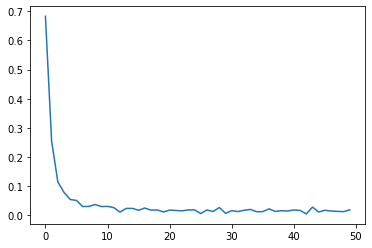

In [11]:
x=range(0,len(train_losses))
plt.plot(x,train_losses)
plt.show()

In [15]:
def get_prediction(logits):
    prob_of_class = F.softmax(logits, dim = 1 )
    _, predicted_class = torch.max(prob_of_class,1)
    return predicted_class
model.eval()
n=0
num_correct_train_data=0
batch_test = 0
for data, target in train_loader:
    print("Batch",batch_test)
    # move-tensors-to-GPU 
#         print(data,type(data))
#         print(target,type(target))
    data = data.to(device)
    target = target.to(device)
 
    # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
    output = model(data)
    #accumulate number of correct labels
    pred_label = get_prediction(output.data)
    n += target.size(0)
    num_correct_train_data += (pred_label == target).sum().item()
    batch_test +=1
accuracy = float(num_correct_train_data)/n *100  
print("Epoch: {} Training accuracy: {}".format(epoch,accuracy))

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928
Batch 929
Batch 930
Batch 931


In [19]:
import torch.onnx 

#Function to Convert to ONNX 
def Convert_ONNX(model): 

    # set the model to inference mode 
    model.eval() 

    # Let's create a dummy input tensor  
    
    dummy_input = torch.randn(1, 3, 64,64, requires_grad=True)  
    
    # Export the model   
    torch.onnx.export(model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         "ImageClassifier.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=10,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['modelInput'],   # the model's input names 
         output_names = ['modelOutput'], # the model's output names 
         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                                'modelOutput' : {0 : 'batch_size'}}) 
    print(" ") 
    print('Model has been converted to ONNX') 
Convert_ONNX(model)

 
Model has been converted to ONNX
